**Salamander Triplet Network**

Created by Alejandro Marin (816035363)

Edited by:

In [ ]:
!pip install -q tensorflow pandas matplotlib opencv-python

In [ ]:
import os
os.listdir()

['.config', 'SeaTurtleID2022.zip', 'metadata.csv', 'sample_data']

# Reattempt From Scratch

## Inherited Code (from Siamese Attempt)

Just copied it down here


In [ ]:
!unzip -q SeaTurtleID2022.zip -d .

In [ ]:
import pandas as pd

# Load the original metadata but remove images
df = pd.read_csv('metadata.csv')

# Fixed the 'path' column to remove 'images/' prefix - using colab and loading each separately, image is WAY too big to load
df['path'] = df['path'].str.replace(r'^images/', '', regex=True)

# Save the fixed version for reuse in later phases
df.to_csv('metadata_fixed.csv', index=False)

print(df.head())


   image_id            identity  \
0         0  LynxID2025_lynx_37   
1         1  LynxID2025_lynx_37   
2         2  LynxID2025_lynx_49   
3         3                 NaN   
4         4  LynxID2025_lynx_13   

                                                path date orientation species  \
0  LynxID2025/database/000f9ee1aad063a4485379ec06...  NaN       right    lynx   
1  LynxID2025/database/0020edb6689e9f78462394d5a6...  NaN        left    lynx   
2  LynxID2025/database/003152e4145b5b6940091d5c12...  NaN        left    lynx   
3  LynxID2025/query/003b89301c7b9f6d18f722082617f...  NaN        back    lynx   
4  LynxID2025/database/003c3f82011e9c3f849f945a93...  NaN       right    lynx   

      split     dataset  
0  database  LynxID2025  
1  database  LynxID2025  
2  database  LynxID2025  
3     query  LynxID2025  
4  database  LynxID2025  


## Step 1 - Load Triplets

Very similar to before with siamese

In [ ]:
import pandas as pd
from collections import defaultdict
import random
from itertools import product

# Load fixed metadata
df = pd.read_csv('metadata_fixed.csv')

# Step 1: Filter for SeaTurtleID2022, database split only
df = df[(df['dataset'] == 'SeaTurtleID2022') & (df['split'] == 'database')]

# Step 2: Drop rows with missing critical data
df = df.dropna(subset=['identity', 'orientation', 'path'])

# Step 3: Group images by identity and orientation
grouped_data = defaultdict(lambda: defaultdict(list))

for _, row in df.iterrows():
    identity = row['identity']
    orientation = row['orientation'].lower()
    path = row['path']
    grouped_data[identity][orientation].append(path)

# Step 4: Generate triplets (anchor, positive, negative)
triplets = []

identities = list(grouped_data.keys())

for identity in identities:
    # Flatten all images under this identity across orientations
    pos_images = [img for imgs in grouped_data[identity].values() for img in imgs]
    if len(pos_images) < 2:
        continue  # Need at least two to form anchor-positive

    # Generate anchor-positive pairs
    for anchor, positive in product(pos_images, pos_images):
        if anchor == positive:
            continue  # Don't pair image with itself

        # Select a negative identity
        negative_candidates = [id2 for id2 in identities if id2 != identity and grouped_data[id2]]
        if not negative_candidates:
            continue

        negative_id = random.choice(negative_candidates)
        negative_imgs = [img for imgs in grouped_data[negative_id].values() for img in imgs]
        if not negative_imgs:
            continue

        negative = random.choice(negative_imgs)
        triplets.append((anchor, positive, negative))

print(f"Generated {len(triplets)} triplets")
print("Example triplet:", triplets[0])


Generated 354210 triplets
Example triplet: ('SeaTurtleID2022/database/turtles-data/data/images/t001/CAluWEgwPX_1.JPG', 'SeaTurtleID2022/database/turtles-data/data/images/t001/ELAvEqeXxT_3.JPG', 'SeaTurtleID2022/database/turtles-data/data/images/t123/umdRlMBVgN_2188.jpg')


Manual Check Using Example Generated:

eafd41b675ff3330_1893 ID: 2

e80dc66902b38838_1881 ID: 2

a0ecd050c2ae1881_1309 ID: 139

In [ ]:
# Load a triplet (anchor, positive, negative) and return ((inputs), dummy_label)
def load_triplet(anchor_path, pos_path, neg_path):
    anchor = preprocess_image(anchor_path)
    positive = preprocess_image(pos_path)
    negative = preprocess_image(neg_path)
    return (anchor, positive, negative), 0.0  # critical fix

In [ ]:
import tensorflow as tf
import random

# Cap triplets
N = 250000
random.shuffle(triplets)

IMG_SIZE = (224, 224)

# Preprocessing function for a single image
def preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = image / 255.0
    return image

# Load a triplet (anchor, positive, negative)
def load_triplet(anchor_path, pos_path, neg_path):
    anchor = preprocess_image(anchor_path)
    positive = preprocess_image(pos_path)
    negative = preprocess_image(neg_path)
    return (anchor, positive, negative), 0.0  # Dummy label

# Convert paths to tensors
anchor_paths = tf.constant([t[0] for t in triplets])
pos_paths    = tf.constant([t[1] for t in triplets])
neg_paths    = tf.constant([t[2] for t in triplets])

# Build dataset
dataset = tf.data.Dataset.from_tensor_slices((anchor_paths, pos_paths, neg_paths))
dataset = dataset.map(load_triplet, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.shuffle(1024).batch(32).prefetch(tf.data.AUTOTUNE)


## Step 2- Define Model

In [ ]:
from tensorflow.keras import layers, Model, regularizers

def create_embedding_network(input_shape=(224, 224, 3)):
    inputs = tf.keras.Input(shape=input_shape)

    x = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128)(x)  # final embedding (no activation)

    return Model(inputs, x, name="EmbeddingNetwork")


## Step 3 - Set Up Model

In [ ]:
embedding_net = create_embedding_network()

input_anchor = tf.keras.Input(shape=(224, 224, 3))
input_positive = tf.keras.Input(shape=(224, 224, 3))
input_negative = tf.keras.Input(shape=(224, 224, 3))

emb_anchor = embedding_net(input_anchor)
emb_positive = embedding_net(input_positive)
emb_negative = embedding_net(input_negative)

model = tf.keras.Model(
    inputs=[input_anchor, input_positive, input_negative],
    outputs=layers.Lambda(lambda x: tf.stack(x, axis=1))([emb_anchor, emb_positive, emb_negative])
)



In [ ]:
def triplet_loss(anchor, positive, negative, margin=1.1):
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)
    loss = tf.maximum(pos_dist - neg_dist + margin, 0.0)
    return tf.reduce_mean(loss)


In [ ]:
def full_triplet_loss(y_true, y_pred):
    anchor = y_pred[:, 0, :]
    positive = y_pred[:, 1, :]
    negative = y_pred[:, 2, :]
    return triplet_loss(anchor, positive, negative)


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss=full_triplet_loss)

model.fit(dataset, epochs=4) #equals AT LEAST 12 hrs lol


Epoch 1/4
11070/11070 ━━━━━━━━━━━━━━━━━━━━ 3116s 281ms/step - loss: 0.1442
Epoch 2/4
11070/11070 ━━━━━━━━━━━━━━━━━━━━ 3109s 281ms/step - loss: 0.1447
Epoch 3/4
11070/11070 ━━━━━━━━━━━━━━━━━━━━ 3114s 281ms/step - loss: 0.1346
Epoch 4/4
11070/11070 ━━━━━━━━━━━━━━━━━━━━ 3109s 281ms/step - loss: 0.1318


Save Model

In [ ]:
# Save the entire triplet model (architecture + weights + optimizer)
model.save("triplet_model.h5")


In [ ]:
model.save_weights('triplet_weights.h5')  # Just weights

# Later, recreate the model and load the weights
model = tf.keras.Model(inputs=[input_anchor, input_positive, input_negative],
                       outputs=[embedding_net(input_anchor), embedding_net(input_positive), embedding_net(input_negative)])
model.load_weights('triplet_weights.h5')


Load:

In [ ]:
from tensorflow.keras.models import load_model

# Custom loss must be passed in again
def triplet_loss(anchor, positive, negative, margin=0.5):
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)
    return tf.reduce_mean(tf.maximum(pos_dist - neg_dist + margin, 0.0))

def full_triplet_loss(y_true, y_pred):
    return triplet_loss(y_pred[0], y_pred[1], y_pred[2])

# Load the model and recompile with custom loss
model = load_model("triplet_model.h5", custom_objects={'full_triplet_loss': full_triplet_loss})


## Manual Test

In [ ]:
import random
import tensorflow as tf

# === Utility to embed a single image ===
def embed_image(path):
    img = preprocess_image(path)
    img = tf.expand_dims(img, axis=0)  # add batch dim
    return embedding_net(img).numpy().squeeze()

# === Step 1: Select 5 Positive Pairs ===
positive_pairs = []

for identity, orientation_dict in grouped_data.items():
    all_imgs = [img for imgs in orientation_dict.values() for img in imgs]
    if len(all_imgs) >= 2:
        img1, img2 = random.sample(all_imgs, 2)
        positive_pairs.append((img1, img2))

    if len(positive_pairs) >= 5:
        break

# === Step 2: Select 5 Negative Pairs ===
negative_pairs = []

ids = list(grouped_data.keys())
while len(negative_pairs) < 5:
    id1, id2 = random.sample(ids, 2)
    imgs1 = [img for imgs in grouped_data[id1].values() for img in imgs]
    imgs2 = [img for imgs in grouped_data[id2].values() for img in imgs]

    if imgs1 and imgs2:
        img1 = random.choice(imgs1)
        img2 = random.choice(imgs2)
        negative_pairs.append((img1, img2))

# === Step 3: Compare distances ===
print("Positive Pairs (Same ID):")
for img1, img2 in positive_pairs:
    emb1 = embed_image(img1)
    emb2 = embed_image(img2)
    dist = tf.norm(emb1 - emb2).numpy()
    print(f"  {img1} <-> {img2} → Distance: {dist:.4f}")

print("\nNegative Pairs (Different ID):")
for img1, img2 in negative_pairs:
    emb1 = embed_image(img1)
    emb2 = embed_image(img2)
    dist = tf.norm(emb1 - emb2).numpy()
    print(f"  {img1} <-> {img2} → Distance: {dist:.4f}")


Positive Pairs (Same ID):
  SeaTurtleID2022/database/turtles-data/data/images/t001/rArWeMiEhi_17.JPG <-> SeaTurtleID2022/database/turtles-data/data/images/t001/CAluWEgwPX_1.JPG → Distance: 1.1306
  SeaTurtleID2022/database/turtles-data/data/images/t002/hPCHQNBqcs_32.JPG <-> SeaTurtleID2022/database/turtles-data/data/images/t002/AWKZYHmepZ_23.JPG → Distance: 2.0820
  SeaTurtleID2022/database/turtles-data/data/images/t003/iUreCLgujg_7777.jpeg <-> SeaTurtleID2022/database/turtles-data/data/images/t003/IsRboHQOvH_42.jpg → Distance: 1.5458
  SeaTurtleID2022/database/turtles-data/data/images/t004/VEmdnrnZaq_87.jpg <-> SeaTurtleID2022/database/turtles-data/data/images/t004/WdDLexzwWs_88.jpg → Distance: 1.0518
  SeaTurtleID2022/database/turtles-data/data/images/t006/dFJLspgzYe_121.jpg <-> SeaTurtleID2022/database/turtles-data/data/images/t006/OkVkJUWvVm_119.JPG → Distance: 2.4621

Negative Pairs (Different ID):
  SeaTurtleID2022/database/turtles-data/data/images/t377/PerYcbLYzt_6777.JPG <-> Se

### Find Better Threshold

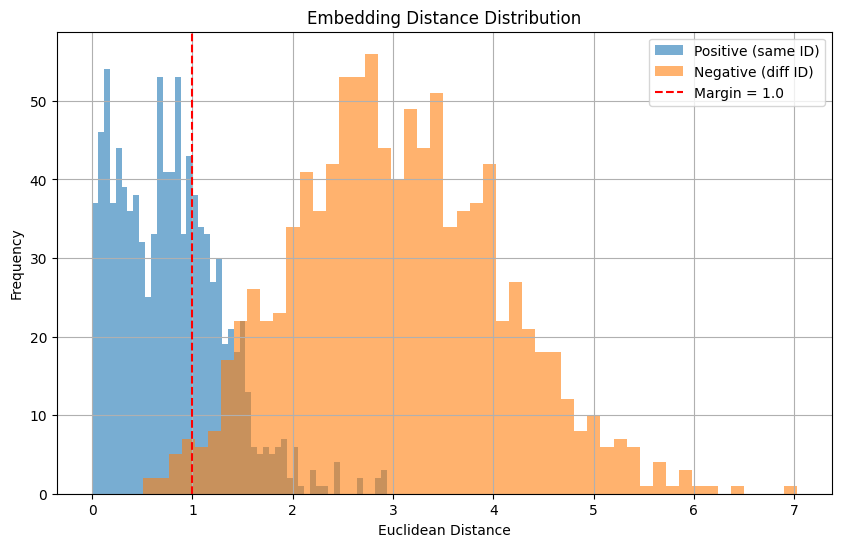

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

positive_distances = []
negative_distances = []

# Loop through a few triplets to compute distances
for anchor_path, pos_path, neg_path in random.sample(triplets, min(1000, len(triplets))):
    anc = preprocess_image(anchor_path)
    pos = preprocess_image(pos_path)
    neg = preprocess_image(neg_path)

    anc_emb = embedding_net(tf.expand_dims(anc, axis=0))
    pos_emb = embedding_net(tf.expand_dims(pos, axis=0))
    neg_emb = embedding_net(tf.expand_dims(neg, axis=0))

    # Euclidean distances
    pos_dist = tf.norm(anc_emb - pos_emb).numpy()
    neg_dist = tf.norm(anc_emb - neg_emb).numpy()

    positive_distances.append(pos_dist)
    negative_distances.append(neg_dist)

# Plotting
plt.figure(figsize=(10, 6))
plt.hist(positive_distances, bins=50, alpha=0.6, label='Positive (same ID)')
plt.hist(negative_distances, bins=50, alpha=0.6, label='Negative (diff ID)')
plt.axvline(x=1.0, color='red', linestyle='--', label='Margin = 1.0')
plt.xlabel("Euclidean Distance")
plt.ylabel("Frequency")
plt.title("Embedding Distance Distribution")
plt.legend()
plt.grid(True)
plt.show()




For reference, this was the one for the siamese:



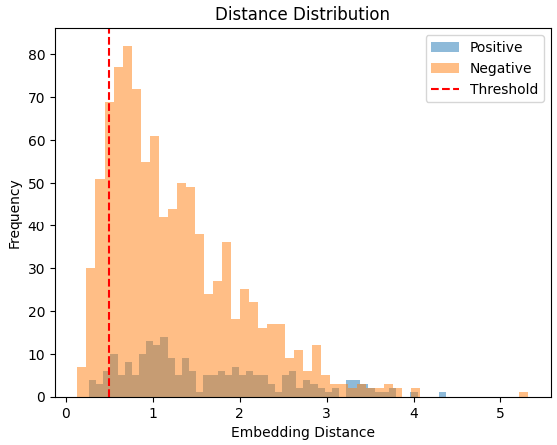

Absolute Optimal

In [ ]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

# --- 1. Load metadata ---
df = pd.read_csv('metadata_fixed.csv')
df = df[(df['dataset'] == 'SeaTurtleID2022') & (df['split'] == 'database')]
df = df.dropna(subset=['identity', 'path'])

# --- 2. Create validation positive and negative pairs ---
from collections import defaultdict
import random

grouped = defaultdict(list)
for _, row in df.iterrows():
    grouped[row['identity']].append(row['path'])

positive_pairs = []
negative_pairs = []

identities = list(grouped.keys())

for identity in identities:
    imgs = grouped[identity]
    if len(imgs) >= 2:
        for i in range(min(2, len(imgs)-1)):
            positive_pairs.append((imgs[i], imgs[i+1], 1))

# Sample negatives
for _ in range(len(positive_pairs)):
    id1, id2 = random.sample(identities, 2)
    img1 = random.choice(grouped[id1])
    img2 = random.choice(grouped[id2])
    negative_pairs.append((img1, img2, 0))

all_pairs = positive_pairs + negative_pairs
random.shuffle(all_pairs)

# --- 3. Preprocessing ---
IMG_SIZE = (224, 224)

def preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    return image / 255.0

def preprocess_pair(img1_path, img2_path, label):
    img1 = preprocess_image(img1_path)
    img2 = preprocess_image(img2_path)
    return (img1, img2), tf.cast(label, tf.float32)

# --- 4. Build val_dataset ---
img1_paths = [p[0] for p in all_pairs]
img2_paths = [p[1] for p in all_pairs]
labels     = [p[2] for p in all_pairs]

val_dataset = tf.data.Dataset.from_tensor_slices((img1_paths, img2_paths, labels))
val_dataset = val_dataset.map(preprocess_pair, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
positive_distances = []
negative_distances = []

for (img1_batch, img2_batch), label_batch in val_dataset:
    for img1, img2, label in zip(img1_batch, img2_batch, label_batch):
        emb1 = embedding_net(tf.expand_dims(img1, 0))
        emb2 = embedding_net(tf.expand_dims(img2, 0))
        dist = tf.norm(emb1 - emb2).numpy()

        if label.numpy() == 1:
            positive_distances.append(dist)
        else:
            negative_distances.append(dist)


In [ ]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score


all_distances = np.array(positive_distances + negative_distances)
all_labels = np.array([1]*len(positive_distances) + [0]*len(negative_distances))

best_f1 = 0
best_threshold = 0

for threshold in np.linspace(0.1, 5.0, 200):
    preds = (all_distances < threshold).astype(int)  # Closer = same individual
    f1 = f1_score(all_labels, preds, zero_division=0)

    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

# Final evaluation
final_preds = (all_distances < best_threshold).astype(int)
precision = precision_score(all_labels, final_preds, zero_division=0)
recall = recall_score(all_labels, final_preds, zero_division=0)

print(f"Best threshold: {best_threshold:.4f}")
print(f"F1 Score: {best_f1:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}")


Best threshold: 2.2668
F1 Score: 0.8311
Precision: 0.8207, Recall: 0.8416


In [ ]:
import numpy as np
from sklearn.metrics import f1_score

all_distances = np.array(positive_distances + negative_distances)
all_labels = np.array([1]*len(positive_distances) + [0]*len(negative_distances))

best_f1 = 0
best_threshold = 0

for threshold in np.linspace(0.1, 5.0, 200):  # Try many values
    preds = (all_distances < threshold).astype(int)  # 1 if close = match
    f1 = f1_score(all_labels, preds)

    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"Best threshold: {best_threshold:.4f} with F1: {best_f1:.4f}")


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metr

Best threshold: 0.0000 with F1: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metr

Visualise

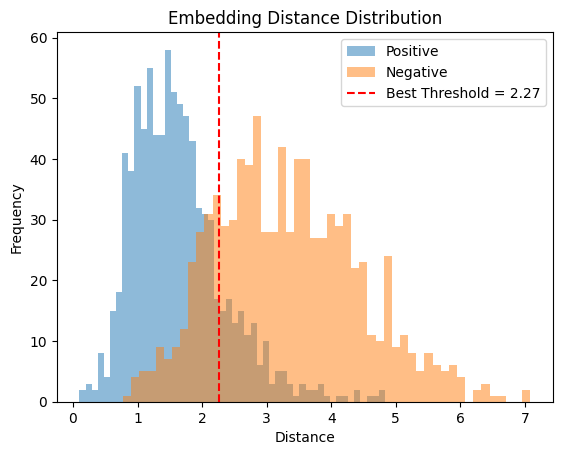

In [ ]:
import matplotlib.pyplot as plt

plt.hist(positive_distances, bins=50, alpha=0.5, label='Positive')
plt.hist(negative_distances, bins=50, alpha=0.5, label='Negative')
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best Threshold = {best_threshold:.2f}')
plt.legend()
plt.title('Embedding Distance Distribution')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.show()


**F1 Scores**

In [ ]:
import numpy as np

all_distances = np.array(positive_distances + negative_distances)
all_labels = np.array([1]*len(positive_distances) + [0]*len(negative_distances))


In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

thresholds = np.linspace(0.1, 5.0, 200)
f1_scores = []
precisions = []
recalls = []

for t in thresholds:
    preds = (all_distances < t).astype(int)
    f1_scores.append(f1_score(all_labels, preds))
    precisions.append(precision_score(all_labels, preds))
    recalls.append(recall_score(all_labels, preds))


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


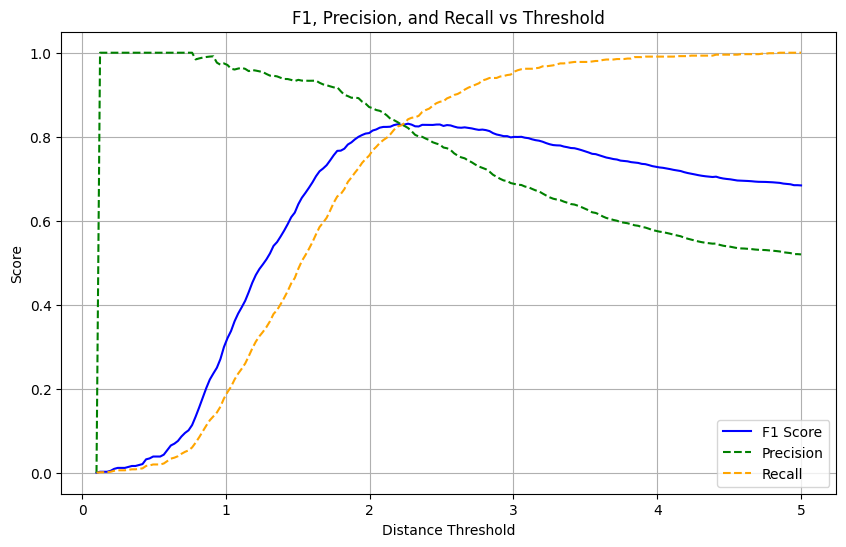

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Score', color='blue')
plt.plot(thresholds, precisions, label='Precision', color='green', linestyle='--')
plt.plot(thresholds, recalls, label='Recall', color='orange', linestyle='--')
plt.xlabel('Distance Threshold')
plt.ylabel('Score')
plt.title('F1, Precision, and Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Best Threshold: {best_threshold:.4f}, F1 Score: {best_f1:.4f}")


Best Threshold: 2.2668, F1 Score: 0.8311


## Step 4.1 - Predict Using Optimal Theshold

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tqdm import tqdm

# Load fixed metadata
df = pd.read_csv("metadata_fixed.csv")

# Filter for SeaTurtleID2022
db_df = df[(df['dataset'] == 'SeaTurtleID2022') & (df['split'] == 'database')].dropna(subset=['identity', 'path'])
query_df = df[(df['dataset'] == 'SeaTurtleID2022') & (df['split'] == 'query')].dropna(subset=['path'])

print(f"DB images: {len(db_df)}, Query images: {len(query_df)}")


DB images: 8729, Query images: 500


In [ ]:
IMG_SIZE = (224, 224)

def preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    return image / 255.0

# Build DB embeddings
db_paths = db_df['path'].tolist()
db_ids = db_df['identity'].tolist()

db_embeddings = []
valid_db_ids = []

for path, identity in tqdm(zip(db_paths, db_ids), total=len(db_paths)):
    try:
        img = preprocess_image(path)
        emb = embedding_net(tf.expand_dims(img, 0)).numpy().squeeze()
        db_embeddings.append(emb)
        valid_db_ids.append(identity)
    except Exception as e:
        print(f"Skipping {path}: {e}")

db_embeddings = np.array(db_embeddings)
print(f"Total valid DB embeddings: {len(db_embeddings)}")


100%|██████████| 8729/8729 [01:36<00:00, 90.76it/s]

Total valid DB embeddings: 8729


In [ ]:
threshold = 1.45  # Based on the histogram

results = []

for _, row in tqdm(query_df.iterrows(), total=len(query_df)):
    path = row['path']
    try:
        img = preprocess_image(path)
        query_emb = embedding_net(tf.expand_dims(img, 0)).numpy().squeeze()

        # Calculate Euclidean distances to all DB embeddings
        dists = np.linalg.norm(db_embeddings - query_emb, axis=1)
        min_idx = np.argmin(dists)
        min_dist = dists[min_idx]

        predicted_id = "new_individual" if min_dist > threshold else valid_db_ids[min_idx]

        results.append({
            'query_path': path,
            'predicted_id': predicted_id,
            'distance': min_dist
        })
    except Exception as e:
        print(f"Error with {path}: {e}")


100%|██████████| 500/500 [00:07<00:00, 67.01it/s]


# The Next Stage

## Add Augmented Phase

Avoid


In [ ]:
def augment_image(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image

def preprocess_image(path, augment=False):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = image / 255.0
    if augment:
        image = augment_image(image)
    return image


In [ ]:
def load_triplet(anchor_path, pos_path, neg_path):
    anchor = preprocess_image(anchor_path, augment=False)   # Anchor stays clean
    positive = preprocess_image(pos_path, augment=True)     # Apply augmentation
    negative = preprocess_image(neg_path, augment=True)
    return (anchor, positive, negative), 0.0


In [ ]:

anchor_paths = tf.constant([t[0] for t in triplets])
pos_paths    = tf.constant([t[1] for t in triplets])
neg_paths    = tf.constant([t[2] for t in triplets])

# Rebuild dataset with augmentation logic
augmented_dataset = tf.data.Dataset.from_tensor_slices((anchor_paths, pos_paths, neg_paths))
augmented_dataset = augmented_dataset.map(load_triplet, num_parallel_calls=tf.data.AUTOTUNE)
augmented_dataset = augmented_dataset.shuffle(1024).batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
model.fit(augmented_dataset, epochs=10)

Epoch 1/10
  636/11070 ━━━━━━━━━━━━━━━━━━━━ 48:43 280ms/step - loss: 0.6470

KeyboardInterrupt: 

# The Next Next Stage

## Add NN

In [ ]:
import pandas as pd
import numpy as np
from collections import defaultdict
import tensorflow as tf
from itertools import combinations
import random

# Load metadata
df = pd.read_csv("/content/metadata_fixed.csv")

# Filter SeaTurtleID2022 and database
df = df[(df['dataset'] == 'SeaTurtleID2022') & (df['split'] == 'database')]
df = df.dropna(subset=['identity', 'orientation', 'path'])

# Group by identity
identity_to_paths = defaultdict(list)
for _, row in df.iterrows():
    identity_to_paths[row['identity']].append(row['path'])

# === Parameters ===
MAX_POS_PER_ID = 10    # Max positive pairs per identity
MAX_TOTAL_NEG = 3000   # Total negative pairs to generate

# Generate positive pairs
positive_pairs = []
for identity, paths in identity_to_paths.items():
    if len(paths) < 2:
        continue
    all_pos = list(combinations(paths, 2))
    selected = random.sample(all_pos, min(len(all_pos), MAX_POS_PER_ID))
    positive_pairs.extend((a, b, 1) for a, b in selected)

# Generate negative pairs
negative_pairs = []
identities = list(identity_to_paths.keys())

while len(negative_pairs) < MAX_TOTAL_NEG:
    id1, id2 = random.sample(identities, 2)
    if not identity_to_paths[id1] or not identity_to_paths[id2]:
        continue
    img1 = random.choice(identity_to_paths[id1])
    img2 = random.choice(identity_to_paths[id2])
    negative_pairs.append((img1, img2, 0))

print("Positive pairs:", len(positive_pairs))
print("Negative pairs:", len(negative_pairs))

# Load embedding network (assumes already defined)
IMG_SIZE = (224, 224)

def preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    return image / 255.0

def compute_embedding(path):
    img = preprocess_image(path)
    img = tf.expand_dims(img, axis=0)
    return embedding_net(img).numpy().squeeze()

# Build dataset of embedding pairs + labels
embedding_pairs = []
labels = []

for img1_path, img2_path, label in positive_pairs + negative_pairs:
    try:
        emb1 = compute_embedding(img1_path)
        emb2 = compute_embedding(img2_path)
        combined = np.concatenate([emb1, emb2])
        embedding_pairs.append(combined)
        labels.append(label)
    except Exception as e:
        print("Failed to process:", img1_path, img2_path)

embedding_pairs = np.array(embedding_pairs)
labels = np.array(labels)
print("Final dataset shape:", embedding_pairs.shape)


Positive pairs: 4055
Negative pairs: 3000
Final dataset shape: (7055, 256)


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    embedding_pairs, labels, test_size=0.2, random_state=42, stratify=labels
)

# Build simple classifier
clf_model = models.Sequential([
    layers.Input(shape=(256,)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

clf_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
clf_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=32
)


Epoch 1/15
177/177 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.6124 - loss: 0.6574 - val_accuracy: 0.8327 - val_loss: 0.3880
Epoch 2/15
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8276 - loss: 0.4173 - val_accuracy: 0.8505 - val_loss: 0.3508
Epoch 3/15
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8567 - loss: 0.3658 - val_accuracy: 0.8675 - val_loss: 0.3308
Epoch 4/15
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8681 - loss: 0.3398 - val_accuracy: 0.8675 - val_loss: 0.3159
Epoch 5/15
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8702 - loss: 0.3110 - val_accuracy: 0.8689 - val_loss: 0.3123
Epoch 6/15
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8765 - loss: 0.3161 - val_accuracy: 0.8696 - val_loss: 0.3126
Epoch 7/15
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8857 - loss: 0.2938 - val_accuracy: 0.8753 - val_loss: 0.3112
Epoch 8/15
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8874 - loss: 0.2836 - val_accuracy: 0

Test Probability

In [ ]:
# Pick 1 positive pair (same identity)
img1_path_pos = "SeaTurtleID2022/database/turtles-data/data/images/t006/s4RZlp19Ej_81.JPG"
img2_path_pos = "SeaTurtleID2022/database/turtles-data/data/images/t006/3nYtb8OBVo_82.JPG"

# Pick 1 negative pair (different identity)
img1_path_neg = "SeaTurtleID2022/database/turtles-data/data/images/t006/s4RZlp19Ej_81.JPG"  # identity 6
img2_path_neg = "SeaTurtleID2022/database/turtles-data/data/images/t008/UOGqRBEmJh_103.JPG"  # identity 8

# Preprocess and embed both
def get_embedding(path):
    img = preprocess_image(path)  # from earlier
    img = tf.expand_dims(img, 0)
    return embedding_net(img).numpy()

# Positive embedding pair
emb1_pos = compute_embedding(img1_path_pos)
emb2_pos = compute_embedding(img2_path_pos)
pair_pos = np.concatenate([emb1_pos, emb2_pos], axis=1)  # shape (1, 256)

# Negative embedding pair
emb1_neg = compute_embedding(img1_path_neg)
emb2_neg = compute_embedding(img2_path_neg)
pair_neg = np.concatenate([emb1_neg, emb2_neg], axis=1)  # shape (1, 256)

# Predict probabilities
prob_pos = clf_model.predict(pair_pos)[0][0]
prob_neg = clf_model.predict(pair_neg)[0][0]

print(f"Positive Pair Probability: {prob_pos:.4f}")
print(f"Negative Pair Probability: {prob_neg:.4f}")


NotFoundError: {{function_node __wrapped__ReadFile_device_/job:localhost/replica:0/task:0/device:CPU:0}} SeaTurtleID2022/database/turtles-data/data/images/t006/s4RZlp19Ej_81.JPG; No such file or directory [Op:ReadFile]

In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
from collections import defaultdict
from tqdm import tqdm

# Load metadata
df = pd.read_csv('metadata_fixed.csv')

# Filter for SeaTurtleID2022 database images
db_df = df[(df['dataset'] == 'SeaTurtleID2022') & (df['split'] == 'database')].dropna(subset=['identity', 'path'])

db_image_paths = db_df['path'].tolist()
db_identities = db_df['identity'].tolist()

# Precompute embeddings
db_embeddings = []
valid_db_paths = []
valid_db_ids = []

for path, identity in tqdm(zip(db_image_paths, db_identities), total=len(db_image_paths)):
    try:
        img = preprocess_image(path)
        img = tf.expand_dims(img, 0)
        emb = embedding_net(img).numpy()
        db_embeddings.append(emb)
        valid_db_paths.append(path)
        valid_db_ids.append(identity)
    except:
        continue

print(f"Loaded {len(db_embeddings)} DB embeddings")


100%|██████████| 8729/8729 [01:38<00:00, 88.60it/s]

✔️ Loaded 8726 DB embeddings


In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf

# --- Load metadata ---
df = pd.read_csv('metadata_fixed.csv')

# --- Get DB (with identity) ---
db_df = df[(df['dataset'] == 'SeaTurtleID2022') & (df['split'] == 'database')].dropna(subset=['identity', 'path'])
db_paths = db_df['path'].tolist()
db_ids = db_df['identity'].tolist()

# Precompute DB embeddings
db_embeddings = []
valid_db_ids = []

for path, identity in tqdm(zip(db_paths, db_ids), desc="DB Embeddings", total=len(db_paths)):
    try:
        img = preprocess_image(path)
        img = tf.expand_dims(img, 0)
        emb = embedding_net(img).numpy().squeeze()
        db_embeddings.append(emb)
        valid_db_ids.append(identity)
    except:
        pass

# --- Get Query images ---
query_df = df[(df['dataset'] == 'SeaTurtleID2022') & (df['split'] == 'query')].dropna(subset=['path'])
query_paths = query_df['path'].tolist()

# --- Predict via NN using batching ---
threshold = 0.5  # Set based on validation or histogram analysis
final_predictions = []

for path in tqdm(query_paths, desc="Predicting"):
    try:
        img = preprocess_image(path)
        img = tf.expand_dims(img, 0)
        q_emb = embedding_net(img).numpy().squeeze()

        # Repeat query emb for each db emb (batch input)
        q_batch = np.repeat(np.expand_dims(q_emb, axis=0), len(db_embeddings), axis=0)
        db_batch = np.array(db_embeddings)

        # Concatenate to form (q_emb | db_emb) pairs
        pair_input = np.concatenate([q_batch, db_batch], axis=1)

        # Predict in batch
        probs = clf_model.predict(pair_input, batch_size=128).squeeze()

        max_idx = np.argmax(probs)
        max_prob = probs[max_idx]

        pred_id = "new_individual" if max_prob < threshold else valid_db_ids[max_idx]
        final_predictions.append((path, pred_id))

    except Exception as e:
        print(f"Error processing {path}: {e}")
        final_predictions.append((path, "error"))

# --- Format results using proper metadata mapping ---
meta_full = pd.read_csv("metadata_fixed.csv")
submission_df = pd.DataFrame(final_predictions, columns=['path', 'identity'])
merged_df = pd.merge(submission_df, meta_full[['path', 'image_id']], how='left', on='path')

final_df = merged_df[['image_id', 'identity']].dropna().astype({'image_id': int})
final_df = final_df.sort_values('image_id')

# Save for submission
final_df.to_csv('salamander_submission.csv', index=False)
print("Salamander submission saved")


Predicting:   0%|          | 0/500 [00:00<?, ?it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Predicting:   0%|          | 1/500 [00:00<06:39,  1.25it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   0%|          | 2/500 [00:01<03:45,  2.21it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   1%|          | 3/500 [00:01<02:47,  2.97it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   1%|          | 4/500 [00:01<02:21,  3.50it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   1%|          | 5/500 [00:01<02:08,  3.86it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   1%|          | 6/500 [00:01<02:00,  4.10it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   1%|▏         | 7/500 [00:02<01:52,  4.39it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   2%|▏         | 8/500 [00:02<01:47,  4.59it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   2%|▏         | 9/500 [00:02<01:44,  4.69it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   2%|▏         | 10/500 [00:02<01:41,  4.83it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   2%|▏         | 11/500 [00:02<01:43,  4.74it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   2%|▏         | 12/500 [00:03<01:41,  4.83it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   3%|▎         | 13/500 [00:03<01:46,  4.56it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   3%|▎         | 14/500 [00:03<01:43,  4.67it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   3%|▎         | 15/500 [00:03<01:40,  4.82it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   3%|▎         | 16/500 [00:03<01:39,  4.87it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   3%|▎         | 17/500 [00:04<01:38,  4.92it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   4%|▎         | 18/500 [00:04<01:37,  4.95it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   4%|▍         | 19/500 [00:04<01:36,  4.98it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   4%|▍         | 20/500 [00:04<01:34,  5.07it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   4%|▍         | 21/500 [00:04<01:35,  5.02it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   4%|▍         | 22/500 [00:05<01:34,  5.05it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   5%|▍         | 23/500 [00:05<01:33,  5.09it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   5%|▍         | 24/500 [00:05<01:33,  5.07it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   5%|▌         | 25/500 [00:05<01:33,  5.11it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   5%|▌         | 26/500 [00:05<01:32,  5.12it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   5%|▌         | 27/500 [00:06<01:32,  5.13it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   6%|▌         | 28/500 [00:06<01:31,  5.15it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   6%|▌         | 29/500 [00:06<01:31,  5.16it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   6%|▌         | 30/500 [00:06<01:30,  5.18it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   6%|▌         | 31/500 [00:06<01:31,  5.14it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   6%|▋         | 32/500 [00:07<01:30,  5.16it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   7%|▋         | 33/500 [00:07<01:31,  5.08it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   7%|▋         | 34/500 [00:07<01:32,  5.06it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   7%|▋         | 35/500 [00:07<01:32,  5.05it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   7%|▋         | 36/500 [00:07<01:31,  5.05it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   7%|▋         | 37/500 [00:08<01:31,  5.08it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   8%|▊         | 38/500 [00:08<01:30,  5.10it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   8%|▊         | 39/500 [00:08<01:30,  5.11it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   8%|▊         | 40/500 [00:08<01:29,  5.15it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   8%|▊         | 41/500 [00:08<01:30,  5.09it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   8%|▊         | 42/500 [00:09<01:34,  4.83it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   9%|▊         | 43/500 [00:09<01:34,  4.81it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   9%|▉         | 44/500 [00:09<01:33,  4.88it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   9%|▉         | 45/500 [00:09<01:32,  4.92it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   9%|▉         | 46/500 [00:09<01:32,  4.93it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   9%|▉         | 47/500 [00:10<01:31,  4.93it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  10%|▉         | 48/500 [00:10<01:30,  5.00it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  10%|▉         | 49/500 [00:10<01:29,  5.03it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  10%|█         | 50/500 [00:10<01:29,  5.05it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  10%|█         | 51/500 [00:10<01:28,  5.09it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  10%|█         | 52/500 [00:11<01:29,  5.03it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  11%|█         | 53/500 [00:11<01:28,  5.07it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  11%|█         | 54/500 [00:11<01:28,  5.07it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  11%|█         | 55/500 [00:11<01:27,  5.07it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  11%|█         | 56/500 [00:11<01:28,  5.02it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  11%|█▏        | 57/500 [00:12<01:31,  4.85it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  12%|█▏        | 58/500 [00:12<01:31,  4.85it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  12%|█▏        | 59/500 [00:12<01:30,  4.87it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  12%|█▏        | 60/500 [00:12<01:32,  4.77it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  12%|█▏        | 61/500 [00:12<01:31,  4.78it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  12%|█▏        | 62/500 [00:13<01:31,  4.80it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  13%|█▎        | 63/500 [00:13<01:31,  4.77it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  13%|█▎        | 64/500 [00:13<01:30,  4.84it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  13%|█▎        | 65/500 [00:13<01:30,  4.82it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  13%|█▎        | 66/500 [00:13<01:28,  4.89it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  13%|█▎        | 67/500 [00:14<01:27,  4.94it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  14%|█▎        | 68/500 [00:14<01:27,  4.96it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  14%|█▍        | 69/500 [00:14<01:27,  4.93it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  14%|█▍        | 70/500 [00:14<01:28,  4.84it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  14%|█▍        | 71/500 [00:14<01:28,  4.85it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  14%|█▍        | 72/500 [00:15<01:32,  4.62it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  15%|█▍        | 73/500 [00:15<01:30,  4.70it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  15%|█▍        | 74/500 [00:15<01:30,  4.70it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  15%|█▌        | 75/500 [00:15<01:28,  4.81it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  15%|█▌        | 76/500 [00:15<01:26,  4.89it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  15%|█▌        | 77/500 [00:16<01:26,  4.91it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  16%|█▌        | 78/500 [00:16<01:27,  4.80it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  16%|█▌        | 79/500 [00:16<01:26,  4.89it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  16%|█▌        | 80/500 [00:16<01:25,  4.94it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  16%|█▌        | 81/500 [00:16<01:26,  4.83it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  16%|█▋        | 82/500 [00:17<01:25,  4.91it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  17%|█▋        | 83/500 [00:17<01:25,  4.88it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  17%|█▋        | 84/500 [00:17<01:24,  4.93it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  17%|█▋        | 85/500 [00:17<01:24,  4.92it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  17%|█▋        | 86/500 [00:18<01:23,  4.97it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  17%|█▋        | 87/500 [00:18<01:22,  5.02it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  18%|█▊        | 88/500 [00:18<01:21,  5.03it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  18%|█▊        | 89/500 [00:18<01:21,  5.06it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  18%|█▊        | 90/500 [00:18<01:20,  5.07it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  18%|█▊        | 91/500 [00:18<01:21,  5.04it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  18%|█▊        | 92/500 [00:19<01:20,  5.06it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Predicting:  19%|█▊        | 93/500 [00:19<01:24,  4.84it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  19%|█▉        | 94/500 [00:19<01:23,  4.88it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  19%|█▉        | 95/500 [00:19<01:22,  4.90it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  19%|█▉        | 96/500 [00:20<01:21,  4.97it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  19%|█▉        | 97/500 [00:20<01:20,  5.03it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  20%|█▉        | 98/500 [00:20<01:20,  4.99it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  20%|█▉        | 99/500 [00:20<01:19,  5.06it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  20%|██        | 100/500 [00:20<01:18,  5.07it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  20%|██        | 101/500 [00:20<01:18,  5.09it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  20%|██        | 102/500 [00:21<01:22,  4.82it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  21%|██        | 103/500 [00:21<01:21,  4.87it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  21%|██        | 104/500 [00:21<01:21,  4.86it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  21%|██        | 105/500 [00:21<01:21,  4.83it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  21%|██        | 106/500 [00:22<02:00,  3.27it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  21%|██▏       | 107/500 [00:22<01:48,  3.61it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  22%|██▏       | 108/500 [00:22<01:40,  3.91it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  22%|██▏       | 109/500 [00:22<01:33,  4.16it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  22%|██▏       | 110/500 [00:23<01:29,  4.34it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  22%|██▏       | 111/500 [00:23<01:26,  4.48it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  22%|██▏       | 112/500 [00:23<01:24,  4.61it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  23%|██▎       | 113/500 [00:23<01:23,  4.63it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  23%|██▎       | 114/500 [00:24<01:22,  4.70it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Predicting:  23%|██▎       | 115/500 [00:24<01:22,  4.64it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  23%|██▎       | 116/500 [00:24<01:23,  4.59it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  23%|██▎       | 117/500 [00:24<01:23,  4.56it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  24%|██▎       | 118/500 [00:24<01:22,  4.62it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  24%|██▍       | 119/500 [00:25<01:20,  4.73it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  24%|██▍       | 120/500 [00:25<01:20,  4.73it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  24%|██▍       | 121/500 [00:25<01:20,  4.73it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  24%|██▍       | 122/500 [00:25<01:19,  4.76it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  25%|██▍       | 123/500 [00:25<01:19,  4.77it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  25%|██▍       | 124/500 [00:26<01:18,  4.80it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  25%|██▌       | 125/500 [00:26<01:17,  4.85it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  25%|██▌       | 126/500 [00:26<01:17,  4.83it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  25%|██▌       | 127/500 [00:26<01:17,  4.79it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  26%|██▌       | 128/500 [00:26<01:17,  4.79it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  26%|██▌       | 129/500 [00:27<01:18,  4.75it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  26%|██▌       | 130/500 [00:27<01:49,  3.38it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  26%|██▌       | 131/500 [00:27<01:41,  3.64it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  26%|██▋       | 132/500 [00:28<01:33,  3.92it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  27%|██▋       | 133/500 [00:28<01:29,  4.12it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  27%|██▋       | 134/500 [00:28<01:24,  4.33it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  27%|██▋       | 135/500 [00:28<01:21,  4.47it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  27%|██▋       | 136/500 [00:28<01:19,  4.60it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  27%|██▋       | 137/500 [00:29<01:16,  4.76it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  28%|██▊       | 138/500 [00:29<01:14,  4.88it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  28%|██▊       | 139/500 [00:29<01:14,  4.86it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  28%|██▊       | 140/500 [00:29<01:14,  4.84it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  28%|██▊       | 141/500 [00:29<01:13,  4.87it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  28%|██▊       | 142/500 [00:30<01:13,  4.90it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  29%|██▊       | 143/500 [00:30<01:12,  4.91it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  29%|██▉       | 144/500 [00:30<01:12,  4.93it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  29%|██▉       | 145/500 [00:30<01:12,  4.92it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  29%|██▉       | 146/500 [00:30<01:12,  4.91it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  29%|██▉       | 147/500 [00:31<01:12,  4.89it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  30%|██▉       | 148/500 [00:31<01:11,  4.92it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  30%|██▉       | 149/500 [00:31<01:12,  4.85it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  30%|███       | 150/500 [00:31<01:11,  4.88it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  30%|███       | 151/500 [00:32<01:12,  4.83it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  30%|███       | 152/500 [00:32<01:11,  4.84it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  31%|███       | 153/500 [00:32<01:11,  4.85it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  31%|███       | 154/500 [00:32<01:11,  4.85it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  31%|███       | 155/500 [00:32<01:11,  4.80it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  31%|███       | 156/500 [00:33<01:11,  4.83it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  31%|███▏      | 157/500 [00:33<01:11,  4.77it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  32%|███▏      | 158/500 [00:33<01:10,  4.83it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  32%|███▏      | 159/500 [00:33<01:09,  4.92it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  32%|███▏      | 160/500 [00:33<01:12,  4.70it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  32%|███▏      | 161/500 [00:34<01:10,  4.77it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  32%|███▏      | 162/500 [00:34<01:09,  4.86it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  33%|███▎      | 163/500 [00:34<01:09,  4.82it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  33%|███▎      | 164/500 [00:34<01:10,  4.80it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  33%|███▎      | 165/500 [00:34<01:11,  4.69it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  33%|███▎      | 166/500 [00:35<01:11,  4.67it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  33%|███▎      | 167/500 [00:35<01:11,  4.68it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  34%|███▎      | 168/500 [00:35<01:10,  4.72it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  34%|███▍      | 169/500 [00:35<01:09,  4.74it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  34%|███▍      | 170/500 [00:35<01:09,  4.73it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  34%|███▍      | 171/500 [00:36<01:09,  4.72it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  34%|███▍      | 172/500 [00:36<01:08,  4.80it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  35%|███▍      | 173/500 [00:36<01:07,  4.84it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  35%|███▍      | 174/500 [00:36<01:07,  4.86it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  35%|███▌      | 175/500 [00:37<01:08,  4.73it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  35%|███▌      | 176/500 [00:37<01:08,  4.76it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  35%|███▌      | 177/500 [00:37<01:07,  4.76it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  36%|███▌      | 178/500 [00:37<01:07,  4.74it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  36%|███▌      | 179/500 [00:37<01:08,  4.70it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  36%|███▌      | 180/500 [00:38<01:07,  4.73it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  36%|███▌      | 181/500 [00:38<01:07,  4.75it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  36%|███▋      | 182/500 [00:38<01:06,  4.76it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  37%|███▋      | 183/500 [00:38<01:06,  4.80it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  37%|███▋      | 184/500 [00:38<01:05,  4.84it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  37%|███▋      | 185/500 [00:39<01:05,  4.83it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  37%|███▋      | 186/500 [00:39<01:04,  4.90it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  37%|███▋      | 187/500 [00:39<01:04,  4.85it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  38%|███▊      | 188/500 [00:39<01:04,  4.82it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  38%|███▊      | 189/500 [00:39<01:05,  4.74it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  38%|███▊      | 190/500 [00:40<01:08,  4.52it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  38%|███▊      | 191/500 [00:40<01:06,  4.63it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  38%|███▊      | 192/500 [00:40<01:05,  4.68it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  39%|███▊      | 193/500 [00:40<01:04,  4.76it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  39%|███▉      | 194/500 [00:41<01:03,  4.80it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  39%|███▉      | 195/500 [00:41<01:02,  4.87it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  39%|███▉      | 196/500 [00:41<01:02,  4.89it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  39%|███▉      | 197/500 [00:41<01:01,  4.92it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  40%|███▉      | 198/500 [00:41<01:00,  4.97it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  40%|███▉      | 199/500 [00:42<01:01,  4.91it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  40%|████      | 200/500 [00:42<01:01,  4.85it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  40%|████      | 201/500 [00:42<01:01,  4.87it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  40%|████      | 202/500 [00:42<01:02,  4.80it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  41%|████      | 203/500 [00:42<01:01,  4.86it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  41%|████      | 204/500 [00:43<01:00,  4.86it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  41%|████      | 205/500 [00:43<01:00,  4.86it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  41%|████      | 206/500 [00:43<01:00,  4.82it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  41%|████▏     | 207/500 [00:43<01:01,  4.76it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  42%|████▏     | 208/500 [00:43<01:00,  4.84it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  42%|████▏     | 209/500 [00:44<00:59,  4.88it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  42%|████▏     | 210/500 [00:44<00:58,  4.97it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  42%|████▏     | 211/500 [00:44<00:58,  4.95it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  42%|████▏     | 212/500 [00:44<00:57,  4.98it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  43%|████▎     | 213/500 [00:44<00:58,  4.93it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  43%|████▎     | 214/500 [00:45<00:57,  4.93it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  43%|████▎     | 215/500 [00:45<00:57,  4.96it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  43%|████▎     | 216/500 [00:45<00:56,  4.98it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  43%|████▎     | 217/500 [00:45<00:57,  4.95it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  44%|████▎     | 218/500 [00:45<00:56,  5.01it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  44%|████▍     | 219/500 [00:46<00:56,  4.99it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  44%|████▍     | 220/500 [00:46<00:59,  4.69it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  44%|████▍     | 221/500 [00:46<00:59,  4.72it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  44%|████▍     | 222/500 [00:46<00:58,  4.77it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  45%|████▍     | 223/500 [00:46<00:57,  4.80it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  45%|████▍     | 224/500 [00:47<00:57,  4.80it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  45%|████▌     | 225/500 [00:47<00:57,  4.79it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  45%|████▌     | 226/500 [00:47<00:57,  4.76it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  45%|████▌     | 227/500 [00:47<00:57,  4.74it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  46%|████▌     | 228/500 [00:48<00:56,  4.79it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  46%|████▌     | 229/500 [00:48<00:56,  4.79it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  46%|████▌     | 230/500 [00:48<00:55,  4.87it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  46%|████▌     | 231/500 [00:48<00:55,  4.88it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  46%|████▋     | 232/500 [00:48<00:54,  4.92it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  47%|████▋     | 233/500 [00:49<00:54,  4.92it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  47%|████▋     | 234/500 [00:49<00:54,  4.88it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  47%|████▋     | 235/500 [00:49<00:55,  4.81it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  47%|████▋     | 236/500 [00:49<00:54,  4.82it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  47%|████▋     | 237/500 [00:49<00:54,  4.80it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  48%|████▊     | 238/500 [00:50<00:54,  4.77it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  48%|████▊     | 239/500 [00:50<00:54,  4.75it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  48%|████▊     | 240/500 [00:50<00:54,  4.77it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  48%|████▊     | 241/500 [00:50<00:53,  4.81it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  48%|████▊     | 242/500 [00:50<00:53,  4.80it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  49%|████▊     | 243/500 [00:51<00:52,  4.86it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  49%|████▉     | 244/500 [00:51<00:52,  4.91it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  49%|████▉     | 245/500 [00:51<00:51,  4.92it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Predicting:  49%|████▉     | 246/500 [00:51<00:52,  4.84it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  49%|████▉     | 247/500 [00:51<00:53,  4.76it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  50%|████▉     | 248/500 [00:52<00:52,  4.79it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  50%|████▉     | 249/500 [00:52<00:54,  4.57it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  50%|█████     | 250/500 [00:52<00:54,  4.60it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  50%|█████     | 251/500 [00:52<00:53,  4.63it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  50%|█████     | 252/500 [00:53<00:53,  4.64it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  51%|█████     | 253/500 [00:53<00:52,  4.72it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  51%|█████     | 254/500 [00:53<00:51,  4.81it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  51%|█████     | 255/500 [00:53<00:50,  4.89it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  51%|█████     | 256/500 [00:53<00:50,  4.87it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  51%|█████▏    | 257/500 [00:54<00:49,  4.88it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  52%|█████▏    | 258/500 [00:54<00:48,  4.97it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  52%|█████▏    | 259/500 [00:54<00:49,  4.92it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  52%|█████▏    | 260/500 [00:54<00:48,  4.92it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  52%|█████▏    | 261/500 [00:54<00:49,  4.88it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  52%|█████▏    | 262/500 [00:55<00:49,  4.83it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  53%|█████▎    | 263/500 [00:55<00:48,  4.86it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  53%|█████▎    | 264/500 [00:55<00:48,  4.90it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  53%|█████▎    | 265/500 [00:55<00:47,  4.91it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  53%|█████▎    | 266/500 [00:55<00:47,  4.95it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  53%|█████▎    | 267/500 [00:56<00:46,  4.97it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  54%|█████▎    | 268/500 [00:56<00:46,  4.97it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  54%|█████▍    | 269/500 [00:56<00:46,  4.97it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  54%|█████▍    | 270/500 [00:56<00:45,  5.02it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  54%|█████▍    | 271/500 [00:56<00:46,  4.93it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  54%|█████▍    | 272/500 [00:57<00:46,  4.93it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  55%|█████▍    | 273/500 [00:57<00:46,  4.88it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  55%|█████▍    | 274/500 [00:57<00:45,  4.92it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  55%|█████▌    | 275/500 [00:57<00:46,  4.85it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  55%|█████▌    | 276/500 [00:57<00:46,  4.86it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  55%|█████▌    | 277/500 [00:58<00:45,  4.87it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  56%|█████▌    | 278/500 [00:58<00:45,  4.91it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  56%|█████▌    | 279/500 [00:58<00:47,  4.63it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  56%|█████▌    | 280/500 [00:58<00:46,  4.69it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  56%|█████▌    | 281/500 [00:58<00:46,  4.73it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  56%|█████▋    | 282/500 [00:59<00:46,  4.72it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  57%|█████▋    | 283/500 [00:59<00:46,  4.71it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  57%|█████▋    | 284/500 [00:59<00:45,  4.77it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  57%|█████▋    | 285/500 [00:59<00:45,  4.77it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  57%|█████▋    | 286/500 [01:00<00:44,  4.77it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  57%|█████▋    | 287/500 [01:00<00:44,  4.75it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  58%|█████▊    | 288/500 [01:00<00:44,  4.77it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  58%|█████▊    | 289/500 [01:00<00:43,  4.81it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  58%|█████▊    | 290/500 [01:00<00:43,  4.83it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  58%|█████▊    | 291/500 [01:01<00:42,  4.88it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  58%|█████▊    | 292/500 [01:01<00:42,  4.94it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  59%|█████▊    | 293/500 [01:01<00:41,  4.94it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  59%|█████▉    | 294/500 [01:01<00:41,  4.91it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  59%|█████▉    | 295/500 [01:01<00:42,  4.86it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Predicting:  59%|█████▉    | 296/500 [01:02<00:42,  4.77it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  59%|█████▉    | 297/500 [01:02<00:42,  4.73it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  60%|█████▉    | 298/500 [01:02<00:42,  4.78it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  60%|█████▉    | 299/500 [01:02<00:42,  4.75it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  60%|██████    | 300/500 [01:02<00:41,  4.76it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  60%|██████    | 301/500 [01:03<00:41,  4.79it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  60%|██████    | 302/500 [01:03<00:40,  4.87it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  61%|██████    | 303/500 [01:03<00:40,  4.84it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  61%|██████    | 304/500 [01:03<00:40,  4.82it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  61%|██████    | 305/500 [01:03<00:39,  4.91it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  61%|██████    | 306/500 [01:04<00:39,  4.93it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  61%|██████▏   | 307/500 [01:04<00:39,  4.87it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  62%|██████▏   | 308/500 [01:04<00:41,  4.66it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  62%|██████▏   | 309/500 [01:04<00:40,  4.70it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  62%|██████▏   | 310/500 [01:05<00:40,  4.72it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  62%|██████▏   | 311/500 [01:05<00:39,  4.79it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  62%|██████▏   | 312/500 [01:05<00:38,  4.83it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  63%|██████▎   | 313/500 [01:05<00:38,  4.87it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  63%|██████▎   | 314/500 [01:05<00:37,  4.91it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  63%|██████▎   | 315/500 [01:06<00:37,  4.91it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  63%|██████▎   | 316/500 [01:06<00:36,  4.99it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  63%|██████▎   | 317/500 [01:06<00:36,  5.00it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  64%|██████▎   | 318/500 [01:06<00:35,  5.06it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  64%|██████▍   | 319/500 [01:06<00:36,  4.95it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  64%|██████▍   | 320/500 [01:07<00:36,  4.97it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  64%|██████▍   | 321/500 [01:07<00:36,  4.97it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  64%|██████▍   | 322/500 [01:07<00:35,  4.97it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  65%|██████▍   | 323/500 [01:07<00:35,  4.96it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  65%|██████▍   | 324/500 [01:07<00:35,  4.91it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  65%|██████▌   | 325/500 [01:08<00:35,  4.87it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  65%|██████▌   | 326/500 [01:08<00:35,  4.91it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  65%|██████▌   | 327/500 [01:08<00:35,  4.91it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  66%|██████▌   | 328/500 [01:08<00:35,  4.89it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  66%|██████▌   | 329/500 [01:08<00:34,  4.93it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  66%|██████▌   | 330/500 [01:09<00:35,  4.85it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  66%|██████▌   | 331/500 [01:09<00:35,  4.81it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  66%|██████▋   | 332/500 [01:09<00:34,  4.81it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  67%|██████▋   | 333/500 [01:09<00:34,  4.83it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  67%|██████▋   | 334/500 [01:09<00:34,  4.78it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  67%|██████▋   | 335/500 [01:10<00:35,  4.69it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  67%|██████▋   | 336/500 [01:10<00:35,  4.64it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  67%|██████▋   | 337/500 [01:10<00:34,  4.75it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  68%|██████▊   | 338/500 [01:10<00:35,  4.61it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  68%|██████▊   | 339/500 [01:10<00:34,  4.72it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  68%|██████▊   | 340/500 [01:11<00:33,  4.81it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  68%|██████▊   | 341/500 [01:11<00:32,  4.85it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  68%|██████▊   | 342/500 [01:11<00:32,  4.88it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  69%|██████▊   | 343/500 [01:11<00:32,  4.83it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  69%|██████▉   | 344/500 [01:11<00:32,  4.81it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  69%|██████▉   | 345/500 [01:12<00:32,  4.83it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  69%|██████▉   | 346/500 [01:12<00:31,  4.82it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  69%|██████▉   | 347/500 [01:12<00:31,  4.82it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  70%|██████▉   | 348/500 [01:12<00:31,  4.83it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  70%|██████▉   | 349/500 [01:13<00:31,  4.84it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  70%|███████   | 350/500 [01:13<00:30,  4.88it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  70%|███████   | 351/500 [01:13<00:30,  4.91it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  70%|███████   | 352/500 [01:13<00:30,  4.85it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  71%|███████   | 353/500 [01:13<00:30,  4.88it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  71%|███████   | 354/500 [01:14<00:30,  4.86it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  71%|███████   | 355/500 [01:14<00:30,  4.78it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  71%|███████   | 356/500 [01:14<00:30,  4.78it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  71%|███████▏  | 357/500 [01:14<00:30,  4.76it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  72%|███████▏  | 358/500 [01:14<00:29,  4.77it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  72%|███████▏  | 359/500 [01:15<00:29,  4.77it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  72%|███████▏  | 360/500 [01:15<00:29,  4.77it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  72%|███████▏  | 361/500 [01:15<00:29,  4.77it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  72%|███████▏  | 362/500 [01:15<00:28,  4.79it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  73%|███████▎  | 363/500 [01:15<00:28,  4.81it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  73%|███████▎  | 364/500 [01:16<00:28,  4.84it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  73%|███████▎  | 365/500 [01:16<00:27,  4.94it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  73%|███████▎  | 366/500 [01:16<00:26,  4.97it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  73%|███████▎  | 367/500 [01:16<00:27,  4.89it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  74%|███████▎  | 368/500 [01:16<00:28,  4.64it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  74%|███████▍  | 369/500 [01:17<00:27,  4.71it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  74%|███████▍  | 370/500 [01:17<00:27,  4.78it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  74%|███████▍  | 371/500 [01:17<00:26,  4.81it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  74%|███████▍  | 372/500 [01:17<00:26,  4.86it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  75%|███████▍  | 373/500 [01:18<00:26,  4.87it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  75%|███████▍  | 374/500 [01:18<00:25,  4.86it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  75%|███████▌  | 375/500 [01:18<00:25,  4.94it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  75%|███████▌  | 376/500 [01:18<00:24,  4.97it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  75%|███████▌  | 377/500 [01:18<00:24,  4.98it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  76%|███████▌  | 378/500 [01:19<00:24,  5.00it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  76%|███████▌  | 379/500 [01:19<00:24,  4.92it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  76%|███████▌  | 380/500 [01:19<00:24,  4.84it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Predicting:  76%|███████▌  | 381/500 [01:19<00:25,  4.71it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  76%|███████▋  | 382/500 [01:19<00:24,  4.75it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  77%|███████▋  | 383/500 [01:20<00:24,  4.83it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  77%|███████▋  | 384/500 [01:20<00:23,  4.86it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  77%|███████▋  | 385/500 [01:20<00:23,  4.90it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  77%|███████▋  | 386/500 [01:20<00:23,  4.76it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  77%|███████▋  | 387/500 [01:20<00:23,  4.80it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  78%|███████▊  | 388/500 [01:21<00:22,  4.88it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  78%|███████▊  | 389/500 [01:21<00:22,  4.91it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  78%|███████▊  | 390/500 [01:21<00:22,  4.94it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Predicting:  78%|███████▊  | 391/500 [01:21<00:22,  4.77it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  78%|███████▊  | 392/500 [01:21<00:22,  4.71it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  79%|███████▊  | 393/500 [01:22<00:22,  4.75it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  79%|███████▉  | 394/500 [01:22<00:21,  4.84it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  79%|███████▉  | 395/500 [01:22<00:21,  4.88it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  79%|███████▉  | 396/500 [01:22<00:21,  4.87it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  79%|███████▉  | 397/500 [01:22<00:21,  4.86it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  80%|███████▉  | 398/500 [01:23<00:21,  4.65it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  80%|███████▉  | 399/500 [01:23<00:21,  4.81it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  80%|████████  | 400/500 [01:23<00:20,  4.87it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  80%|████████  | 401/500 [01:23<00:20,  4.94it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  80%|████████  | 402/500 [01:23<00:19,  4.99it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  81%|████████  | 403/500 [01:24<00:19,  4.99it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  81%|████████  | 404/500 [01:24<00:19,  4.96it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  81%|████████  | 405/500 [01:24<00:19,  4.90it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  81%|████████  | 406/500 [01:24<00:19,  4.85it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  81%|████████▏ | 407/500 [01:24<00:19,  4.88it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  82%|████████▏ | 408/500 [01:25<00:18,  4.87it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  82%|████████▏ | 409/500 [01:25<00:18,  4.89it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  82%|████████▏ | 410/500 [01:25<00:18,  4.92it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  82%|████████▏ | 411/500 [01:25<00:18,  4.90it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  82%|████████▏ | 412/500 [01:26<00:17,  4.90it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  83%|████████▎ | 413/500 [01:26<00:17,  4.87it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  83%|████████▎ | 414/500 [01:26<00:17,  4.91it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  83%|████████▎ | 415/500 [01:26<00:17,  4.86it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  83%|████████▎ | 416/500 [01:26<00:17,  4.86it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  83%|████████▎ | 417/500 [01:27<00:17,  4.83it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  84%|████████▎ | 418/500 [01:27<00:16,  4.85it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  84%|████████▍ | 419/500 [01:27<00:16,  4.84it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  84%|████████▍ | 420/500 [01:27<00:16,  4.85it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  84%|████████▍ | 421/500 [01:27<00:16,  4.88it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  84%|████████▍ | 422/500 [01:28<00:15,  4.94it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  85%|████████▍ | 423/500 [01:28<00:15,  4.88it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  85%|████████▍ | 424/500 [01:28<00:15,  4.97it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  85%|████████▌ | 425/500 [01:28<00:14,  5.02it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  85%|████████▌ | 426/500 [01:28<00:14,  5.05it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  85%|████████▌ | 427/500 [01:29<00:15,  4.83it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  86%|████████▌ | 428/500 [01:29<00:14,  4.88it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  86%|████████▌ | 429/500 [01:29<00:14,  4.82it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  86%|████████▌ | 430/500 [01:29<00:14,  4.78it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  86%|████████▌ | 431/500 [01:29<00:14,  4.73it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  86%|████████▋ | 432/500 [01:30<00:14,  4.76it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  87%|████████▋ | 433/500 [01:30<00:13,  4.84it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  87%|████████▋ | 434/500 [01:30<00:13,  4.93it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  87%|████████▋ | 435/500 [01:30<00:13,  4.93it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  87%|████████▋ | 436/500 [01:30<00:12,  4.95it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  87%|████████▋ | 437/500 [01:31<00:12,  5.03it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  88%|████████▊ | 438/500 [01:31<00:12,  5.05it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  88%|████████▊ | 439/500 [01:31<00:12,  5.01it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  88%|████████▊ | 440/500 [01:31<00:11,  5.00it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Predicting:  88%|████████▊ | 441/500 [01:31<00:12,  4.90it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  88%|████████▊ | 442/500 [01:32<00:12,  4.83it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  89%|████████▊ | 443/500 [01:32<00:11,  4.79it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  89%|████████▉ | 444/500 [01:32<00:11,  4.81it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  89%|████████▉ | 445/500 [01:32<00:11,  4.80it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  89%|████████▉ | 446/500 [01:33<00:11,  4.63it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  89%|████████▉ | 447/500 [01:33<00:11,  4.64it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  90%|████████▉ | 448/500 [01:33<00:10,  4.76it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  90%|████████▉ | 449/500 [01:33<00:10,  4.88it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  90%|█████████ | 450/500 [01:33<00:10,  4.91it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  90%|█████████ | 451/500 [01:34<00:10,  4.86it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  90%|█████████ | 452/500 [01:34<00:09,  4.87it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  91%|█████████ | 453/500 [01:34<00:09,  4.85it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  91%|█████████ | 454/500 [01:34<00:09,  4.90it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  91%|█████████ | 455/500 [01:34<00:09,  4.94it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  91%|█████████ | 456/500 [01:35<00:08,  4.96it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  91%|█████████▏| 457/500 [01:35<00:08,  4.80it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  92%|█████████▏| 458/500 [01:35<00:08,  4.87it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  92%|█████████▏| 459/500 [01:35<00:08,  4.91it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  92%|█████████▏| 460/500 [01:35<00:08,  4.98it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  92%|█████████▏| 461/500 [01:36<00:07,  4.93it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  92%|█████████▏| 462/500 [01:36<00:07,  4.98it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  93%|█████████▎| 463/500 [01:36<00:07,  4.93it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  93%|█████████▎| 464/500 [01:36<00:07,  4.90it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  93%|█████████▎| 465/500 [01:36<00:07,  4.76it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  93%|█████████▎| 466/500 [01:37<00:07,  4.76it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  93%|█████████▎| 467/500 [01:37<00:06,  4.75it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  94%|█████████▎| 468/500 [01:37<00:06,  4.73it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  94%|█████████▍| 469/500 [01:37<00:06,  4.70it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  94%|█████████▍| 470/500 [01:37<00:06,  4.70it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  94%|█████████▍| 471/500 [01:38<00:06,  4.73it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  94%|█████████▍| 472/500 [01:38<00:05,  4.68it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  95%|█████████▍| 473/500 [01:38<00:05,  4.76it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  95%|█████████▍| 474/500 [01:38<00:05,  4.84it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  95%|█████████▌| 475/500 [01:39<00:05,  4.80it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  95%|█████████▌| 476/500 [01:39<00:05,  4.80it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  95%|█████████▌| 477/500 [01:39<00:04,  4.78it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  96%|█████████▌| 478/500 [01:39<00:04,  4.79it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  96%|█████████▌| 479/500 [01:39<00:04,  4.82it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  96%|█████████▌| 480/500 [01:40<00:04,  4.85it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  96%|█████████▌| 481/500 [01:40<00:03,  4.89it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  96%|█████████▋| 482/500 [01:40<00:03,  4.94it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  97%|█████████▋| 483/500 [01:40<00:03,  4.94it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  97%|█████████▋| 484/500 [01:40<00:03,  4.97it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  97%|█████████▋| 485/500 [01:41<00:03,  4.99it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  97%|█████████▋| 486/500 [01:41<00:02,  5.05it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  97%|█████████▋| 487/500 [01:41<00:02,  4.74it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  98%|█████████▊| 488/500 [01:41<00:02,  4.75it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  98%|█████████▊| 489/500 [01:41<00:02,  4.67it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  98%|█████████▊| 490/500 [01:42<00:02,  4.73it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  98%|█████████▊| 491/500 [01:42<00:01,  4.76it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  98%|█████████▊| 492/500 [01:42<00:01,  4.85it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  99%|█████████▊| 493/500 [01:42<00:01,  4.88it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  99%|█████████▉| 494/500 [01:42<00:01,  4.88it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  99%|█████████▉| 495/500 [01:43<00:01,  4.87it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  99%|█████████▉| 496/500 [01:43<00:00,  4.87it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  99%|█████████▉| 497/500 [01:43<00:00,  4.86it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting: 100%|█████████▉| 498/500 [01:43<00:00,  4.85it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting: 100%|█████████▉| 499/500 [01:43<00:00,  4.77it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting: 100%|██████████| 500/500 [01:44<00:00,  4.80it/s]

Salamander submission saved


In [ ]:
# Map image_id from metadata
path_to_id = dict(zip(df['path'], df['image_id']))

submission = []

for path, pred in final_predictions.items():
    img_id = path_to_id.get(path, None)
    if img_id is not None:
        submission.append((img_id, pred))

# Convert to DataFrame and save
sub_df = pd.DataFrame(submission, columns=['image_id', 'identity'])
sub_df = sub_df.sort_values(by='image_id')
sub_df.to_csv('salamander_submission.csv', index=False)

print("✅ Submission saved as salamander_submission.csv")


AttributeError: 'list' object has no attribute 'items'

# Export

For NN:

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf

# --- Load metadata ---
df = pd.read_csv('metadata_fixed.csv')

# --- Get DB (with identity) ---
db_df = df[(df['dataset'] == 'SeaTurtleID2022') & (df['split'] == 'database')].dropna(subset=['identity', 'path'])
db_paths = db_df['path'].tolist()
db_ids = db_df['identity'].tolist()

# Precompute DB embeddings
db_embeddings = []
valid_db_ids = []

for path, identity in tqdm(zip(db_paths, db_ids), desc="DB Embeddings", total=len(db_paths)):
    try:
        img = preprocess_image(path)
        img = tf.expand_dims(img, 0)
        emb = embedding_net(img).numpy().squeeze()
        db_embeddings.append(emb)
        valid_db_ids.append(identity)
    except:
        pass

# --- Get Query images ---
query_df = df[(df['dataset'] == 'SeaTurtleID2022') & (df['split'] == 'query')].dropna(subset=['path'])
query_paths = query_df['path'].tolist()

# --- Predict via NN using batching ---
threshold = 0.5
final_predictions = []

for path in tqdm(query_paths, desc="Predicting"):
    try:
        img = preprocess_image(path)
        img = tf.expand_dims(img, 0)
        q_emb = embedding_net(img).numpy().squeeze()

        # Repeat query emb for each db emb
        q_batch = np.repeat(np.expand_dims(q_emb, axis=0), len(db_embeddings), axis=0)
        db_batch = np.array(db_embeddings)

        # Concatenate for classifier
        pair_input = np.concatenate([q_batch, db_batch], axis=1)
        probs = clf_model.predict(pair_input, batch_size=128).squeeze()

        max_idx = np.argmax(probs)
        max_prob = probs[max_idx]

        pred_id = "new_individual" if max_prob < threshold else valid_db_ids[max_idx]
        final_predictions.append((path, pred_id))

    except Exception as e:
        print(f"Error processing {path}: {e}")
        final_predictions.append((path, "error"))

# --- Format and save submission CSV ---
meta_full = pd.read_csv("metadata_fixed.csv")
submission_df = pd.DataFrame(final_predictions, columns=['path', 'identity'])
merged_df = pd.merge(submission_df, meta_full[['path', 'image_id']], how='left', on='path')

final_df = merged_df[['image_id', 'identity']].dropna().astype({'image_id': int})
final_df = final_df.sort_values('image_id')

final_df.to_csv('sea_turtle_submission.csv', index=False)
print("Sea Turtle submission saved as 'sea_turtle_submission.csv'")


Predicting:   0%|          | 0/500 [00:00<?, ?it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   0%|          | 1/500 [00:00<01:44,  4.77it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   0%|          | 2/500 [00:00<01:43,  4.81it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   1%|          | 3/500 [00:00<01:42,  4.85it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   1%|          | 4/500 [00:00<01:44,  4.76it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   1%|          | 5/500 [00:01<01:45,  4.70it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   1%|          | 6/500 [00:01<01:45,  4.67it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   1%|▏         | 7/500 [00:01<01:44,  4.71it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   2%|▏         | 8/500 [00:01<01:45,  4.68it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   2%|▏         | 9/500 [00:01<01:46,  4.60it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   2%|▏         | 10/500 [00:02<01:45,  4.62it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   2%|▏         | 11/500 [00:02<01:45,  4.65it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   2%|▏         | 12/500 [00:02<01:42,  4.74it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   3%|▎         | 13/500 [00:02<01:41,  4.79it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   3%|▎         | 14/500 [00:02<01:40,  4.82it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   3%|▎         | 15/500 [00:03<01:39,  4.85it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   3%|▎         | 16/500 [00:03<01:44,  4.65it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   3%|▎         | 17/500 [00:03<01:43,  4.66it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   4%|▎         | 18/500 [00:03<01:41,  4.75it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   4%|▍         | 19/500 [00:04<01:40,  4.80it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   4%|▍         | 20/500 [00:04<01:39,  4.85it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   4%|▍         | 21/500 [00:04<01:39,  4.84it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   4%|▍         | 22/500 [00:04<01:38,  4.84it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   5%|▍         | 23/500 [00:04<01:40,  4.76it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   5%|▍         | 24/500 [00:05<01:40,  4.76it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   5%|▌         | 25/500 [00:05<01:38,  4.82it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   5%|▌         | 26/500 [00:05<01:36,  4.89it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   5%|▌         | 27/500 [00:05<01:35,  4.94it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   6%|▌         | 28/500 [00:05<01:34,  4.98it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   6%|▌         | 29/500 [00:06<01:34,  4.96it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   6%|▌         | 30/500 [00:06<01:34,  4.95it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   6%|▌         | 31/500 [00:06<01:34,  4.97it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   6%|▋         | 32/500 [00:06<01:33,  5.00it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   7%|▋         | 33/500 [00:06<01:35,  4.90it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   7%|▋         | 34/500 [00:07<01:35,  4.89it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   7%|▋         | 35/500 [00:07<01:34,  4.90it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   7%|▋         | 36/500 [00:07<01:34,  4.92it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   7%|▋         | 37/500 [00:07<01:33,  4.93it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   8%|▊         | 38/500 [00:07<01:34,  4.90it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   8%|▊         | 39/500 [00:08<01:34,  4.87it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   8%|▊         | 40/500 [00:08<01:34,  4.85it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   8%|▊         | 41/500 [00:08<01:33,  4.89it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   8%|▊         | 42/500 [00:08<01:33,  4.88it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   9%|▊         | 43/500 [00:08<01:33,  4.89it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   9%|▉         | 44/500 [00:09<01:31,  4.96it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   9%|▉         | 45/500 [00:09<01:32,  4.90it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   9%|▉         | 46/500 [00:09<01:37,  4.67it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   9%|▉         | 47/500 [00:09<01:37,  4.66it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  10%|▉         | 48/500 [00:09<01:36,  4.69it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  10%|▉         | 49/500 [00:10<01:34,  4.77it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  10%|█         | 50/500 [00:10<01:33,  4.80it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  10%|█         | 51/500 [00:10<01:32,  4.84it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  10%|█         | 52/500 [00:10<01:32,  4.84it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  11%|█         | 53/500 [00:10<01:30,  4.92it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  11%|█         | 54/500 [00:11<01:29,  4.99it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  11%|█         | 55/500 [00:11<01:28,  5.02it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  11%|█         | 56/500 [00:11<01:28,  5.04it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  11%|█▏        | 57/500 [00:11<01:29,  4.95it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  12%|█▏        | 58/500 [00:11<01:29,  4.94it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  12%|█▏        | 59/500 [00:12<01:30,  4.88it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  12%|█▏        | 60/500 [00:12<01:34,  4.67it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  12%|█▏        | 61/500 [00:12<01:34,  4.66it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  12%|█▏        | 62/500 [00:12<01:33,  4.67it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  13%|█▎        | 63/500 [00:13<01:32,  4.71it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  13%|█▎        | 64/500 [00:13<01:32,  4.72it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  13%|█▎        | 65/500 [00:13<01:33,  4.67it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  13%|█▎        | 66/500 [00:13<01:32,  4.67it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  13%|█▎        | 67/500 [00:13<01:31,  4.72it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  14%|█▎        | 68/500 [00:14<01:29,  4.81it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  14%|█▍        | 69/500 [00:14<01:30,  4.78it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  14%|█▍        | 70/500 [00:14<01:29,  4.81it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  14%|█▍        | 71/500 [00:14<01:29,  4.81it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  14%|█▍        | 72/500 [00:14<01:30,  4.75it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  15%|█▍        | 73/500 [00:15<01:28,  4.82it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  15%|█▍        | 74/500 [00:15<01:30,  4.73it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  15%|█▌        | 75/500 [00:15<01:28,  4.79it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  15%|█▌        | 76/500 [00:15<01:32,  4.61it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  15%|█▌        | 77/500 [00:16<01:29,  4.72it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  16%|█▌        | 78/500 [00:16<01:30,  4.67it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  16%|█▌        | 79/500 [00:16<01:28,  4.74it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  16%|█▌        | 80/500 [00:16<01:26,  4.84it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  16%|█▌        | 81/500 [00:16<01:28,  4.76it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  16%|█▋        | 82/500 [00:17<01:27,  4.76it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  17%|█▋        | 83/500 [00:17<01:27,  4.76it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  17%|█▋        | 84/500 [00:17<01:27,  4.76it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  17%|█▋        | 85/500 [00:17<01:28,  4.71it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  17%|█▋        | 86/500 [00:17<01:26,  4.80it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  17%|█▋        | 87/500 [00:18<01:26,  4.79it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  18%|█▊        | 88/500 [00:18<01:24,  4.85it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  18%|█▊        | 89/500 [00:18<01:24,  4.88it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  18%|█▊        | 90/500 [00:18<01:22,  4.95it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  18%|█▊        | 91/500 [00:18<01:21,  5.00it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  18%|█▊        | 92/500 [00:19<01:22,  4.97it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  19%|█▊        | 93/500 [00:19<01:22,  4.91it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  19%|█▉        | 94/500 [00:19<01:22,  4.91it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  19%|█▉        | 95/500 [00:19<01:22,  4.93it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  19%|█▉        | 96/500 [00:19<01:21,  4.93it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  19%|█▉        | 97/500 [00:20<01:21,  4.95it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  20%|█▉        | 98/500 [00:20<01:21,  4.94it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  20%|█▉        | 99/500 [00:20<01:21,  4.95it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  20%|██        | 100/500 [00:20<01:20,  4.96it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  20%|██        | 101/500 [00:20<01:19,  4.99it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  20%|██        | 102/500 [00:21<01:18,  5.05it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  21%|██        | 103/500 [00:21<01:18,  5.08it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  21%|██        | 104/500 [00:21<01:18,  5.02it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  21%|██        | 105/500 [00:21<01:23,  4.75it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  21%|██        | 106/500 [00:21<01:22,  4.76it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  21%|██▏       | 107/500 [00:22<01:22,  4.79it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  22%|██▏       | 108/500 [00:22<01:21,  4.82it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  22%|██▏       | 109/500 [00:22<01:21,  4.81it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  22%|██▏       | 110/500 [00:22<01:21,  4.78it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  22%|██▏       | 111/500 [00:23<01:20,  4.85it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  22%|██▏       | 112/500 [00:23<01:19,  4.91it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  23%|██▎       | 113/500 [00:23<01:18,  4.90it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  23%|██▎       | 114/500 [00:23<01:18,  4.94it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  23%|██▎       | 115/500 [00:23<01:19,  4.84it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  23%|██▎       | 116/500 [00:24<01:19,  4.83it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  23%|██▎       | 117/500 [00:24<01:20,  4.78it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  24%|██▎       | 118/500 [00:24<01:20,  4.76it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  24%|██▍       | 119/500 [00:24<01:20,  4.70it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  24%|██▍       | 120/500 [00:24<01:22,  4.61it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  24%|██▍       | 121/500 [00:25<01:21,  4.63it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  24%|██▍       | 122/500 [00:25<01:20,  4.69it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  25%|██▍       | 123/500 [00:25<01:19,  4.75it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  25%|██▍       | 124/500 [00:25<01:18,  4.77it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  25%|██▌       | 125/500 [00:25<01:18,  4.79it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  25%|██▌       | 126/500 [00:26<01:17,  4.83it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  25%|██▌       | 127/500 [00:26<01:16,  4.85it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  26%|██▌       | 128/500 [00:26<01:16,  4.88it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  26%|██▌       | 129/500 [00:26<01:16,  4.84it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  26%|██▌       | 130/500 [00:26<01:16,  4.86it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  26%|██▌       | 131/500 [00:27<01:17,  4.77it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  26%|██▋       | 132/500 [00:27<01:16,  4.79it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Predicting:  27%|██▋       | 133/500 [00:27<01:17,  4.74it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  27%|██▋       | 134/500 [00:27<01:15,  4.83it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  27%|██▋       | 135/500 [00:28<01:18,  4.64it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  27%|██▋       | 136/500 [00:28<01:17,  4.70it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  27%|██▋       | 137/500 [00:28<01:17,  4.70it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  28%|██▊       | 138/500 [00:28<01:15,  4.80it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  28%|██▊       | 139/500 [00:28<01:13,  4.89it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  28%|██▊       | 140/500 [00:29<01:12,  4.94it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  28%|██▊       | 141/500 [00:29<01:13,  4.91it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  28%|██▊       | 142/500 [00:29<01:12,  4.96it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  29%|██▊       | 143/500 [00:29<01:12,  4.95it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  29%|██▉       | 144/500 [00:29<01:11,  4.96it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  29%|██▉       | 145/500 [00:30<01:11,  4.93it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  29%|██▉       | 146/500 [00:30<01:11,  4.96it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  29%|██▉       | 147/500 [00:30<01:11,  4.94it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  30%|██▉       | 148/500 [00:30<01:10,  4.98it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  30%|██▉       | 149/500 [00:30<01:11,  4.90it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  30%|███       | 150/500 [00:31<01:10,  4.94it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  30%|███       | 151/500 [00:31<01:10,  4.95it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  30%|███       | 152/500 [00:31<01:09,  4.99it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  31%|███       | 153/500 [00:31<01:10,  4.93it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  31%|███       | 154/500 [00:31<01:10,  4.94it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  31%|███       | 155/500 [00:32<01:11,  4.85it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  31%|███       | 156/500 [00:32<01:10,  4.88it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  31%|███▏      | 157/500 [00:32<01:11,  4.81it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  32%|███▏      | 158/500 [00:32<01:10,  4.85it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  32%|███▏      | 159/500 [00:32<01:09,  4.91it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  32%|███▏      | 160/500 [00:33<01:08,  4.93it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  32%|███▏      | 161/500 [00:33<01:08,  4.97it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  32%|███▏      | 162/500 [00:33<01:07,  5.03it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  33%|███▎      | 163/500 [00:33<01:07,  5.01it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  33%|███▎      | 164/500 [00:33<01:07,  5.01it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  33%|███▎      | 165/500 [00:34<01:11,  4.71it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  33%|███▎      | 166/500 [00:34<01:10,  4.76it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  33%|███▎      | 167/500 [00:34<01:09,  4.79it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  34%|███▎      | 168/500 [00:34<01:08,  4.84it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  34%|███▍      | 169/500 [00:34<01:07,  4.90it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  34%|███▍      | 170/500 [00:35<01:07,  4.86it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  34%|███▍      | 171/500 [00:35<01:08,  4.84it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  34%|███▍      | 172/500 [00:35<01:07,  4.86it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  35%|███▍      | 173/500 [00:35<01:07,  4.85it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  35%|███▍      | 174/500 [00:35<01:06,  4.89it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  35%|███▌      | 175/500 [00:36<01:09,  4.70it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Predicting:  35%|███▌      | 176/500 [00:36<01:09,  4.69it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  35%|███▌      | 177/500 [00:36<01:08,  4.69it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  36%|███▌      | 178/500 [00:36<01:08,  4.72it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  36%|███▌      | 179/500 [00:37<01:07,  4.77it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  36%|███▌      | 180/500 [00:37<01:06,  4.79it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  36%|███▌      | 181/500 [00:37<01:06,  4.81it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  36%|███▋      | 182/500 [00:37<01:05,  4.84it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  37%|███▋      | 183/500 [00:37<01:05,  4.84it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  37%|███▋      | 184/500 [00:38<01:06,  4.78it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  37%|███▋      | 185/500 [00:38<01:05,  4.78it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  37%|███▋      | 186/500 [00:38<01:04,  4.88it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  37%|███▋      | 187/500 [00:38<01:03,  4.95it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  38%|███▊      | 188/500 [00:38<01:02,  5.01it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  38%|███▊      | 189/500 [00:39<01:03,  4.91it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  38%|███▊      | 190/500 [00:39<01:04,  4.82it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  38%|███▊      | 191/500 [00:39<01:03,  4.85it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  38%|███▊      | 192/500 [00:39<01:03,  4.85it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  39%|███▊      | 193/500 [00:39<01:03,  4.84it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  39%|███▉      | 194/500 [00:40<01:03,  4.81it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  39%|███▉      | 195/500 [00:40<01:05,  4.64it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  39%|███▉      | 196/500 [00:40<01:04,  4.72it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  39%|███▉      | 197/500 [00:40<01:04,  4.67it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  40%|███▉      | 198/500 [00:41<01:03,  4.76it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  40%|███▉      | 199/500 [00:41<01:02,  4.85it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  40%|████      | 200/500 [00:41<01:00,  4.94it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  40%|████      | 201/500 [00:41<01:01,  4.88it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  40%|████      | 202/500 [00:41<01:01,  4.88it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  41%|████      | 203/500 [00:42<01:00,  4.93it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  41%|████      | 204/500 [00:42<00:59,  4.97it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  41%|████      | 205/500 [00:42<00:59,  4.99it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  41%|████      | 206/500 [00:42<00:58,  4.99it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  41%|████▏     | 207/500 [00:42<00:59,  4.90it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  42%|████▏     | 208/500 [00:43<00:59,  4.92it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  42%|████▏     | 209/500 [00:43<00:59,  4.89it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  42%|████▏     | 210/500 [00:43<00:58,  4.98it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  42%|████▏     | 211/500 [00:43<00:57,  5.00it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  42%|████▏     | 212/500 [00:43<00:57,  5.04it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  43%|████▎     | 213/500 [00:44<00:57,  4.98it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  43%|████▎     | 214/500 [00:44<00:57,  4.96it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  43%|████▎     | 215/500 [00:44<00:57,  4.99it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  43%|████▎     | 216/500 [00:44<00:56,  5.00it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  43%|████▎     | 217/500 [00:44<00:56,  4.99it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  44%|████▎     | 218/500 [00:45<00:56,  4.97it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  44%|████▍     | 219/500 [00:45<00:56,  4.97it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  44%|████▍     | 220/500 [00:45<00:56,  4.99it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  44%|████▍     | 221/500 [00:45<00:56,  4.96it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  44%|████▍     | 222/500 [00:45<00:56,  4.92it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  45%|████▍     | 223/500 [00:46<00:56,  4.94it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  45%|████▍     | 224/500 [00:46<00:57,  4.80it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  45%|████▌     | 225/500 [00:46<00:58,  4.73it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  45%|████▌     | 226/500 [00:46<00:58,  4.69it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  45%|████▌     | 227/500 [00:46<00:59,  4.63it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  46%|████▌     | 228/500 [00:47<00:59,  4.61it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  46%|████▌     | 229/500 [00:47<00:59,  4.59it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  46%|████▌     | 230/500 [00:47<00:58,  4.62it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  46%|████▌     | 231/500 [00:47<00:57,  4.64it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Predicting:  46%|████▋     | 232/500 [00:48<00:58,  4.62it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  47%|████▋     | 233/500 [00:48<00:56,  4.70it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  47%|████▋     | 234/500 [00:48<00:57,  4.67it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  47%|████▋     | 235/500 [00:48<00:56,  4.69it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  47%|████▋     | 236/500 [00:48<00:54,  4.81it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  47%|████▋     | 237/500 [00:49<00:55,  4.72it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  48%|████▊     | 238/500 [00:49<00:55,  4.73it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  48%|████▊     | 239/500 [00:49<00:55,  4.74it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  48%|████▊     | 240/500 [00:49<00:54,  4.76it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  48%|████▊     | 241/500 [00:49<00:54,  4.76it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  48%|████▊     | 242/500 [00:50<00:54,  4.71it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  49%|████▊     | 243/500 [00:50<00:54,  4.74it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  49%|████▉     | 244/500 [00:50<00:53,  4.76it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  49%|████▉     | 245/500 [00:50<00:53,  4.81it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  49%|████▉     | 246/500 [00:50<00:52,  4.86it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  49%|████▉     | 247/500 [00:51<00:51,  4.89it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  50%|████▉     | 248/500 [00:51<00:50,  4.96it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  50%|████▉     | 249/500 [00:51<00:51,  4.88it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  50%|█████     | 250/500 [00:51<00:51,  4.89it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  50%|█████     | 251/500 [00:51<00:50,  4.90it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  50%|█████     | 252/500 [00:52<00:52,  4.73it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  51%|█████     | 253/500 [00:52<00:52,  4.74it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  51%|█████     | 254/500 [00:52<00:54,  4.49it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  51%|█████     | 255/500 [00:52<00:53,  4.55it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  51%|█████     | 256/500 [00:53<00:52,  4.61it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  51%|█████▏    | 257/500 [00:53<00:52,  4.66it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  52%|█████▏    | 258/500 [00:53<00:50,  4.75it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  52%|█████▏    | 259/500 [00:53<00:49,  4.84it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  52%|█████▏    | 260/500 [00:53<00:48,  4.92it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  52%|█████▏    | 261/500 [00:54<00:49,  4.84it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  52%|█████▏    | 262/500 [00:54<00:49,  4.80it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  53%|█████▎    | 263/500 [00:54<00:49,  4.83it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  53%|█████▎    | 264/500 [00:54<00:48,  4.86it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  53%|█████▎    | 265/500 [00:54<00:49,  4.80it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  53%|█████▎    | 266/500 [00:55<00:48,  4.79it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  53%|█████▎    | 267/500 [00:55<00:48,  4.85it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  54%|█████▎    | 268/500 [00:55<00:47,  4.90it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  54%|█████▍    | 269/500 [00:55<00:47,  4.88it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  54%|█████▍    | 270/500 [00:55<00:46,  4.94it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  54%|█████▍    | 271/500 [00:56<00:46,  4.93it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  54%|█████▍    | 272/500 [00:56<00:45,  5.01it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  55%|█████▍    | 273/500 [00:56<00:46,  4.91it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  55%|█████▍    | 274/500 [00:56<00:45,  4.93it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  55%|█████▌    | 275/500 [00:56<00:45,  4.93it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  55%|█████▌    | 276/500 [00:57<00:45,  4.92it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  55%|█████▌    | 277/500 [00:57<00:45,  4.90it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  56%|█████▌    | 278/500 [00:57<00:45,  4.91it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  56%|█████▌    | 279/500 [00:57<00:44,  4.93it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  56%|█████▌    | 280/500 [00:57<00:44,  4.95it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  56%|█████▌    | 281/500 [00:58<00:44,  4.87it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  56%|█████▋    | 282/500 [00:58<00:45,  4.83it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  57%|█████▋    | 283/500 [00:58<00:45,  4.77it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  57%|█████▋    | 284/500 [00:58<00:47,  4.58it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  57%|█████▋    | 285/500 [00:59<00:46,  4.60it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  57%|█████▋    | 286/500 [00:59<00:46,  4.60it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  57%|█████▋    | 287/500 [00:59<00:45,  4.66it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  58%|█████▊    | 288/500 [00:59<00:44,  4.75it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  58%|█████▊    | 289/500 [00:59<00:43,  4.80it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  58%|█████▊    | 290/500 [01:00<00:43,  4.82it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  58%|█████▊    | 291/500 [01:00<00:43,  4.85it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  58%|█████▊    | 292/500 [01:00<00:42,  4.88it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  59%|█████▊    | 293/500 [01:00<00:42,  4.90it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  59%|█████▉    | 294/500 [01:00<00:42,  4.90it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  59%|█████▉    | 295/500 [01:01<00:41,  4.96it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  59%|█████▉    | 296/500 [01:01<00:40,  4.99it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  59%|█████▉    | 297/500 [01:01<00:41,  4.93it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  60%|█████▉    | 298/500 [01:01<00:40,  4.94it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  60%|█████▉    | 299/500 [01:01<00:41,  4.85it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  60%|██████    | 300/500 [01:02<00:41,  4.85it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  60%|██████    | 301/500 [01:02<00:41,  4.80it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  60%|██████    | 302/500 [01:02<00:40,  4.84it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  61%|██████    | 303/500 [01:02<00:39,  4.93it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  61%|██████    | 304/500 [01:02<00:39,  4.91it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  61%|██████    | 305/500 [01:03<00:39,  4.96it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  61%|██████    | 306/500 [01:03<00:39,  4.97it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  61%|██████▏   | 307/500 [01:03<00:38,  5.00it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  62%|██████▏   | 308/500 [01:03<00:38,  5.05it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  62%|██████▏   | 309/500 [01:03<00:38,  5.01it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  62%|██████▏   | 310/500 [01:04<00:38,  4.97it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  62%|██████▏   | 311/500 [01:04<00:38,  4.94it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  62%|██████▏   | 312/500 [01:04<00:38,  4.92it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  63%|██████▎   | 313/500 [01:04<00:39,  4.70it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Predicting:  63%|██████▎   | 314/500 [01:04<00:40,  4.59it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  63%|██████▎   | 315/500 [01:05<00:39,  4.64it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  63%|██████▎   | 316/500 [01:05<00:38,  4.73it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  63%|██████▎   | 317/500 [01:05<00:38,  4.81it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  64%|██████▎   | 318/500 [01:05<00:37,  4.89it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  64%|██████▍   | 319/500 [01:05<00:36,  4.97it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  64%|██████▍   | 320/500 [01:06<00:36,  5.00it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  64%|██████▍   | 321/500 [01:06<00:36,  4.96it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  64%|██████▍   | 322/500 [01:06<00:35,  4.96it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  65%|██████▍   | 323/500 [01:06<00:35,  4.98it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  65%|██████▍   | 324/500 [01:07<00:35,  5.00it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  65%|██████▌   | 325/500 [01:07<00:34,  5.02it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  65%|██████▌   | 326/500 [01:07<00:34,  5.03it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  65%|██████▌   | 327/500 [01:07<00:34,  5.03it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  66%|██████▌   | 328/500 [01:07<00:34,  5.00it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  66%|██████▌   | 329/500 [01:07<00:34,  5.01it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  66%|██████▌   | 330/500 [01:08<00:34,  4.99it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  66%|██████▌   | 331/500 [01:08<00:33,  4.98it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  66%|██████▋   | 332/500 [01:08<00:33,  5.01it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  67%|██████▋   | 333/500 [01:08<00:33,  5.00it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  67%|██████▋   | 334/500 [01:08<00:33,  5.03it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  67%|██████▋   | 335/500 [01:09<00:33,  4.93it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  67%|██████▋   | 336/500 [01:09<00:33,  4.83it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  67%|██████▋   | 337/500 [01:09<00:34,  4.74it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Predicting:  68%|██████▊   | 338/500 [01:09<00:34,  4.71it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  68%|██████▊   | 339/500 [01:10<00:33,  4.77it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  68%|██████▊   | 340/500 [01:10<00:33,  4.81it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  68%|██████▊   | 341/500 [01:10<00:33,  4.78it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  68%|██████▊   | 342/500 [01:10<00:33,  4.71it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  69%|██████▊   | 343/500 [01:10<00:34,  4.53it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  69%|██████▉   | 344/500 [01:11<00:33,  4.67it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  69%|██████▉   | 345/500 [01:11<00:32,  4.72it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  69%|██████▉   | 346/500 [01:11<00:32,  4.74it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  69%|██████▉   | 347/500 [01:11<00:31,  4.80it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  70%|██████▉   | 348/500 [01:11<00:31,  4.84it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  70%|██████▉   | 349/500 [01:12<00:31,  4.82it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  70%|███████   | 350/500 [01:12<00:30,  4.86it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  70%|███████   | 351/500 [01:12<00:30,  4.82it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  70%|███████   | 352/500 [01:12<00:30,  4.86it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  71%|███████   | 353/500 [01:12<00:30,  4.89it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  71%|███████   | 354/500 [01:13<00:29,  4.92it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  71%|███████   | 355/500 [01:13<00:29,  4.94it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  71%|███████   | 356/500 [01:13<00:28,  4.98it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  71%|███████▏  | 357/500 [01:13<00:29,  4.88it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  72%|███████▏  | 358/500 [01:14<00:29,  4.86it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  72%|███████▏  | 359/500 [01:14<00:29,  4.82it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  72%|███████▏  | 360/500 [01:14<00:28,  4.84it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  72%|███████▏  | 361/500 [01:14<00:28,  4.80it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  72%|███████▏  | 362/500 [01:14<00:28,  4.81it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  73%|███████▎  | 363/500 [01:15<00:28,  4.81it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  73%|███████▎  | 364/500 [01:15<00:28,  4.84it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  73%|███████▎  | 365/500 [01:15<00:27,  4.89it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  73%|███████▎  | 366/500 [01:15<00:27,  4.95it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  73%|███████▎  | 367/500 [01:15<00:26,  4.97it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  74%|███████▎  | 368/500 [01:16<00:26,  5.01it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  74%|███████▍  | 369/500 [01:16<00:26,  4.96it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  74%|███████▍  | 370/500 [01:16<00:26,  4.96it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  74%|███████▍  | 371/500 [01:16<00:26,  4.96it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  74%|███████▍  | 372/500 [01:16<00:25,  4.97it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  75%|███████▍  | 373/500 [01:17<00:27,  4.64it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  75%|███████▍  | 374/500 [01:17<00:27,  4.63it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  75%|███████▌  | 375/500 [01:17<00:26,  4.70it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  75%|███████▌  | 376/500 [01:17<00:26,  4.76it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  75%|███████▌  | 377/500 [01:17<00:25,  4.82it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  76%|███████▌  | 378/500 [01:18<00:25,  4.86it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  76%|███████▌  | 379/500 [01:18<00:24,  4.92it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  76%|███████▌  | 380/500 [01:18<00:24,  4.91it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  76%|███████▌  | 381/500 [01:18<00:24,  4.91it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  76%|███████▋  | 382/500 [01:18<00:24,  4.90it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  77%|███████▋  | 383/500 [01:19<00:23,  4.90it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  77%|███████▋  | 384/500 [01:19<00:23,  4.87it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  77%|███████▋  | 385/500 [01:19<00:23,  4.88it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  77%|███████▋  | 386/500 [01:19<00:23,  4.83it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  77%|███████▋  | 387/500 [01:19<00:23,  4.86it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  78%|███████▊  | 388/500 [01:20<00:22,  4.89it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  78%|███████▊  | 389/500 [01:20<00:22,  4.91it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  78%|███████▊  | 390/500 [01:20<00:22,  4.94it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  78%|███████▊  | 391/500 [01:20<00:21,  4.99it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  78%|███████▊  | 392/500 [01:20<00:22,  4.90it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Predicting:  79%|███████▊  | 393/500 [01:21<00:22,  4.74it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  79%|███████▉  | 394/500 [01:21<00:22,  4.77it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  79%|███████▉  | 395/500 [01:21<00:22,  4.71it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  79%|███████▉  | 396/500 [01:21<00:22,  4.69it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  79%|███████▉  | 397/500 [01:22<00:22,  4.65it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  80%|███████▉  | 398/500 [01:22<00:21,  4.66it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  80%|███████▉  | 399/500 [01:22<00:21,  4.77it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Predicting:  80%|████████  | 400/500 [01:22<00:21,  4.71it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  80%|████████  | 401/500 [01:22<00:20,  4.75it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  80%|████████  | 402/500 [01:23<00:20,  4.82it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  81%|████████  | 403/500 [01:23<00:20,  4.65it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  81%|████████  | 404/500 [01:23<00:20,  4.75it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  81%|████████  | 405/500 [01:23<00:19,  4.77it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  81%|████████  | 406/500 [01:23<00:19,  4.80it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  81%|████████▏ | 407/500 [01:24<00:19,  4.84it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  82%|████████▏ | 408/500 [01:24<00:19,  4.83it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  82%|████████▏ | 409/500 [01:24<00:18,  4.83it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  82%|████████▏ | 410/500 [01:24<00:18,  4.82it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  82%|████████▏ | 411/500 [01:24<00:18,  4.81it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  82%|████████▏ | 412/500 [01:25<00:18,  4.85it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  83%|████████▎ | 413/500 [01:25<00:17,  4.86it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  83%|████████▎ | 414/500 [01:25<00:17,  4.88it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  83%|████████▎ | 415/500 [01:25<00:17,  4.88it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  83%|████████▎ | 416/500 [01:25<00:17,  4.92it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  83%|████████▎ | 417/500 [01:26<00:17,  4.82it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  84%|████████▎ | 418/500 [01:26<00:17,  4.82it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  84%|████████▍ | 419/500 [01:26<00:16,  4.81it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  84%|████████▍ | 420/500 [01:26<00:16,  4.76it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  84%|████████▍ | 421/500 [01:27<00:16,  4.83it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  84%|████████▍ | 422/500 [01:27<00:15,  4.88it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  85%|████████▍ | 423/500 [01:27<00:15,  4.85it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  85%|████████▍ | 424/500 [01:27<00:15,  4.93it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  85%|████████▌ | 425/500 [01:27<00:15,  4.93it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  85%|████████▌ | 426/500 [01:28<00:14,  4.94it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  85%|████████▌ | 427/500 [01:28<00:14,  4.98it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  86%|████████▌ | 428/500 [01:28<00:14,  4.92it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  86%|████████▌ | 429/500 [01:28<00:14,  4.80it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  86%|████████▌ | 430/500 [01:28<00:14,  4.84it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  86%|████████▌ | 431/500 [01:29<00:14,  4.79it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  86%|████████▋ | 432/500 [01:29<00:14,  4.59it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  87%|████████▋ | 433/500 [01:29<00:14,  4.71it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  87%|████████▋ | 434/500 [01:29<00:13,  4.81it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  87%|████████▋ | 435/500 [01:29<00:13,  4.78it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  87%|████████▋ | 436/500 [01:30<00:13,  4.84it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  87%|████████▋ | 437/500 [01:30<00:12,  4.90it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  88%|████████▊ | 438/500 [01:30<00:12,  4.91it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  88%|████████▊ | 439/500 [01:30<00:12,  4.97it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  88%|████████▊ | 440/500 [01:30<00:11,  5.00it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  88%|████████▊ | 441/500 [01:31<00:11,  4.99it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  88%|████████▊ | 442/500 [01:31<00:11,  4.94it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  89%|████████▊ | 443/500 [01:31<00:11,  4.89it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  89%|████████▉ | 444/500 [01:31<00:11,  4.88it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  89%|████████▉ | 445/500 [01:31<00:11,  4.93it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  89%|████████▉ | 446/500 [01:32<00:11,  4.75it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  89%|████████▉ | 447/500 [01:32<00:11,  4.73it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  90%|████████▉ | 448/500 [01:32<00:11,  4.71it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  90%|████████▉ | 449/500 [01:32<00:10,  4.81it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  90%|█████████ | 450/500 [01:33<00:10,  4.83it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Predicting:  90%|█████████ | 451/500 [01:33<00:10,  4.76it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  90%|█████████ | 452/500 [01:33<00:10,  4.74it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Predicting:  91%|█████████ | 453/500 [01:33<00:10,  4.61it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  91%|█████████ | 454/500 [01:33<00:09,  4.66it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  91%|█████████ | 455/500 [01:34<00:09,  4.71it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  91%|█████████ | 456/500 [01:34<00:09,  4.76it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  91%|█████████▏| 457/500 [01:34<00:08,  4.79it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  92%|█████████▏| 458/500 [01:34<00:08,  4.82it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  92%|█████████▏| 459/500 [01:34<00:08,  4.83it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  92%|█████████▏| 460/500 [01:35<00:08,  4.87it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  92%|█████████▏| 461/500 [01:35<00:08,  4.82it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  92%|█████████▏| 462/500 [01:35<00:08,  4.63it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  93%|█████████▎| 463/500 [01:35<00:07,  4.74it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  93%|█████████▎| 464/500 [01:35<00:07,  4.81it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  93%|█████████▎| 465/500 [01:36<00:07,  4.72it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  93%|█████████▎| 466/500 [01:36<00:07,  4.77it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  93%|█████████▎| 467/500 [01:36<00:06,  4.75it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  94%|█████████▎| 468/500 [01:36<00:06,  4.73it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  94%|█████████▍| 469/500 [01:37<00:06,  4.73it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  94%|█████████▍| 470/500 [01:37<00:06,  4.77it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  94%|█████████▍| 471/500 [01:37<00:06,  4.80it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  94%|█████████▍| 472/500 [01:37<00:05,  4.78it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  95%|█████████▍| 473/500 [01:37<00:05,  4.84it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  95%|█████████▍| 474/500 [01:38<00:05,  4.87it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  95%|█████████▌| 475/500 [01:38<00:05,  4.88it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  95%|█████████▌| 476/500 [01:38<00:04,  4.84it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  95%|█████████▌| 477/500 [01:38<00:04,  4.80it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  96%|█████████▌| 478/500 [01:38<00:04,  4.71it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  96%|█████████▌| 479/500 [01:39<00:04,  4.73it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  96%|█████████▌| 480/500 [01:39<00:04,  4.79it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  96%|█████████▌| 481/500 [01:39<00:03,  4.83it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  96%|█████████▋| 482/500 [01:39<00:03,  4.87it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  97%|█████████▋| 483/500 [01:39<00:03,  4.80it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  97%|█████████▋| 484/500 [01:40<00:03,  4.85it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  97%|█████████▋| 485/500 [01:40<00:03,  4.88it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  97%|█████████▋| 486/500 [01:40<00:02,  4.93it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  97%|█████████▋| 487/500 [01:40<00:02,  4.96it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  98%|█████████▊| 488/500 [01:40<00:02,  4.97it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  98%|█████████▊| 489/500 [01:41<00:02,  4.82it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  98%|█████████▊| 490/500 [01:41<00:02,  4.85it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  98%|█████████▊| 491/500 [01:41<00:01,  4.66it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  98%|█████████▊| 492/500 [01:41<00:01,  4.70it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  99%|█████████▊| 493/500 [01:42<00:01,  4.76it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  99%|█████████▉| 494/500 [01:42<00:01,  4.71it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  99%|█████████▉| 495/500 [01:42<00:01,  4.76it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  99%|█████████▉| 496/500 [01:42<00:00,  4.86it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  99%|█████████▉| 497/500 [01:42<00:00,  4.91it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting: 100%|█████████▉| 498/500 [01:43<00:00,  4.91it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting: 100%|█████████▉| 499/500 [01:43<00:00,  4.89it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting: 100%|██████████| 500/500 [01:43<00:00,  4.83it/s]


✅ Sea Turtle submission saved as 'sea_turtle_submission.csv'


For Triplet:

In [ ]:
# Load original metadata again to get query image_id
full_df = pd.read_csv("metadata_fixed.csv")
query_meta = full_df[(full_df['dataset'] == 'SeaTurtleID2022') & (full_df['split'] == 'query')]

# Map query path to image_id
path_to_id = dict(zip(query_meta['path'], query_meta['image_id']))

submission_df = pd.DataFrame({
    'image_id': [path_to_id[r['query_path']] for r in results],
    'identity': [r['predicted_id'] for r in results]
})

submission_df = submission_df.sort_values("image_id")  # Optional, for consistency
submission_df.to_csv("sea_turtle_triplet_submission2.csv", index=False)

print("Salamander submission saved!")
submission_df.head()


Salamander submission saved!


,image_id,identity
0,14709,SeaTurtleID2022_t095
1,14710,SeaTurtleID2022_t033
2,14711,SeaTurtleID2022_t251
3,14712,SeaTurtleID2022_t459
4,14713,SeaTurtleID2022_t217
